# Welke factoren/variabelen hebben invloed op de kwaliteit (scores/ratings) van wijn (Robert Parker)?

Deelvragen:
1. Hoe gedragen het gemiddelde en de mediaan van de scores zich over tijd?
2. Zijn er specifieke wijnen met grote ranges van scores over de jaren heen? Of juist wijnen die het ieder jaar goed doen?
3. Wat is het gemiddelde en de mediaan van de scores per country (land) / region / ... (visualiseer op de kaart?)
4. Zijn er producers die significant hogere ratings krijgen dan andere producers?
5. Zijn in bepaalde jaren de scores significant hoger dan in andere jaren? Wat was er dit jaar aan de hand?
6. Geven specifieke reviewers significant hogere of lagere scores aan wijnen?
7. Zijn de scores van pure wijnen significant hoger dan blends (variety)?
8. In hoeverre zijn de sweetness / color / producer / type / reviewer / variety / locatie ... van invloed op de score van de wijn? Is dit significant te toetsen?
9. Wat valt er op aan de bijgevoegde begeleidende tekst? Tekst analyse? Lengte van de begeleide tekst van invloed?

In [1]:
import cred
import re
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By


# Get data from Robert Parker

In [2]:
url = "https://www.robertparker.com/sign-in"

try:
    driver = webdriver.Chrome() 
except:
    raise Exception("There is an error loading the Chromedriver. Make sure to have Chromium / Google Chrome installed. Review https://chromedriver.chromium.org/getting-started for more information!")

In [3]:
# Try to open sign-in URL
try:
    driver.get(url)
except:
    raise Exception("Page could not be loaded. Did you run previous codeblock?")

# Wait max 10 seconds until at-field-username_and_email is found in the HTML code (field used to login)
print(f'Wait untill login page is loaded ...')
try:
    elem = WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.ID, "at-field-username_and_email"))
)
except:
    raise Exception("Login page could not be loaded. Please retry before continuing")

# Notify if cred.py not available in current dir
if not "cred.py" in os.listdir():
    raise Exception("cred.py is not availble. Make sure there is a cred.py with username and password in there") 

username = cred.username
password = cred.password

# Find the login fields and fill in credentials
driver.find_element("id", "at-field-username_and_email").send_keys(username)
driver.find_element("id", "at-field-password").send_keys(password)

# Search for the login button and click
driver.find_element(By.CSS_SELECTOR, ".btn-primary[data-loading-text='Processing…']").click()

# Wait max 10 seconds until search-options-inner is found in the HTML code (searchbar on homepage)
print(f'Wait untill homepage is loaded ...')
try:
    elem = WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.CSS_SELECTOR, ".search-options-inner")) 
)
except:
    raise Exception("Homepage could not be loaded. Please retry before continuing.")

print("All done. Ready to continue.")

Wait untill login page is loaded ...
Wait untill homepage is loaded ...
All done. Ready to continue.


In [4]:
country = "Germany"

In [5]:
search_results = []

# Get initial page! 
url = fr'https://www.robertparker.com/search/wines?expand=true&show-tasting-note=true&country[]={country}'
driver.get(url)

# Wait max 10 seconds until the ratings are loadded on the website
try: 
    elem = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, ".control-label"))
    )
except:
    print("No results found. Continue without ratings.")


page_html = BeautifulSoup(driver.page_source, 'html.parser')

# Check number of pages
max_page_html = page_html.find('a', href=True, attrs={'aria-label': "Last"})['href']
regex = re.compile("(\d+)")
max_page_number = int(re.search(regex, max_page_html).group())

# Construct page urls
page_urls = [f'{url}&page={i+1}' for i in range(1,max_page_number)]

search_results.extend(page_html.find_all('div', class_= 'tasting-notes')) # all results will be added to search_results

In [6]:
for i, url in enumerate(page_urls, start=2):
    print(f'Requesting page {i} of {len(page_urls)+1}...')     
    driver.get(url)

    # Wait max 15 seconds until the ratings are loadded on the website
    try: 
        elem = WebDriverWait(driver, 20).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, ".control-label"))
        )
    except:
        print(f' No results found on page {i} - Continue without ratings.')
        # write to logger to notify for missing data
    
    page_html = BeautifulSoup(driver.page_source, 'html.parser')
    search_results.extend(page_html.find_all('div', class_= 'tasting-notes')) # all results will be added to search_results

Requesting page 2 of 498...
Requesting page 3 of 498...
Requesting page 4 of 498...
Requesting page 5 of 498...
Requesting page 6 of 498...
Requesting page 7 of 498...
Requesting page 8 of 498...
Requesting page 9 of 498...
Requesting page 10 of 498...
Requesting page 11 of 498...
Requesting page 12 of 498...
Requesting page 13 of 498...
Requesting page 14 of 498...
Requesting page 15 of 498...
Requesting page 16 of 498...
Requesting page 17 of 498...
Requesting page 18 of 498...
Requesting page 19 of 498...
Requesting page 20 of 498...
Requesting page 21 of 498...
Requesting page 22 of 498...
Requesting page 23 of 498...
Requesting page 24 of 498...
Requesting page 25 of 498...
Requesting page 26 of 498...
Requesting page 27 of 498...
Requesting page 28 of 498...
Requesting page 29 of 498...
Requesting page 30 of 498...
Requesting page 31 of 498...
Requesting page 32 of 498...
Requesting page 33 of 498...
Requesting page 34 of 498...
Requesting page 35 of 498...
Requesting page 36 of 

In [10]:
def get_variable(variable: str, wine) -> str:
    """ Find variable in search result (wine) """
    result = wine.find(lambda tag: tag.name == 'p' and variable in tag.text)
    result = get_text(result)

    if "Rating" in variable:
        return result.replace(variable, "")
        
    if result:
        return clean_variable(result, variable)
    else:
        return None


def get_text(input):
    return input.text if input else None
   

def clean_variable(input: str, replaceword: str) -> str: 
    """ Remove variable word (e.g. "drink_date:") from result """
    result = input.replace(replaceword, "") # remove_variable_word
    result = re.sub(r'[^A-Za-z0-9,. ]+', '', result) # remove_non_word_characters (enters / slashes etc.)
    return result


def get_data_from_search_results(search_results: list) -> pd.DataFrame:
    """ Get variables from search results and return in a DataFrame """

    vars = ['title', 'rating', 'drink_date', 'reviewed_by', 'issue_date', 'source', 'content', 'producer', 'from_location', 'color', 'type', 'sweetness', 'variety']
    df = pd.DataFrame(columns=vars)

    for wine in search_results:
    
        title = get_text(wine.find('h3', class_='titular'))
        rating = get_variable('Rating: ', wine)
        drink_date = get_variable('Drink Date:', wine)
        reviewed_by = get_variable('Reviewed by:', wine)
        issue_date = get_variable('Issue Date:', wine)
        source = get_variable('Source:', wine)
        content = get_text(wine.find('p', class_='tasting-note-content'))
        producer = get_variable('Producer:', wine)
        from_location = get_variable('From:', wine)
        color = get_variable('Color:', wine)
        type = get_variable('Type:', wine)
        sweetness = get_variable('Sweetness:', wine)
        variety = get_variable('Variety:', wine)

        new_wine = {'title': title,
                'rating': rating,
                'drink_date': drink_date,
                'reviewed_by': reviewed_by,
                'issue_date': issue_date, 
                'source': source, 
                'content': content,
                'producer': producer,
                'from_location': from_location,
                'color': color,
                'type': type,
                'sweetness': sweetness,
                'variety': variety}

        df.loc[len(df)] = new_wine
    
    return df

In [11]:
df = get_data_from_search_results(search_results)

print(df.shape) 
df

(24889, 13)


title rating   drink_date   
0      NV Andreas Durst • Spatburgunder Dorf Pfalzer ...     88   2015  2017  \
1      NV Andreas Durst • Spätburgunder Dorf (Los-Nr ...     87   2019  2025   
2      NV Andreas Durst • Spätburgunder Dorf (Los-Nr ...     90   2021  2028   
3      NV Andreas Durst • Spätburgunder Dorf (Los-Nr ...     89   2019  2027   
4      NV Andreas Durst • Spätburgunder Dorf (Los-Nr ...     89   2022  2030   
...                                                  ...    ...          ...   
24884   1937 Robert Weil • Kiedricher Gräfenberg Cabinet     94   2020  2050   
24885   1934 Robert Weil • Kiedricher Gräfenberg Cabinet     87   2020  2026   
24886   1921 Robert Weil • Kiedricher Gräfenberg Cabinet     88           NA   
24887                  1921 Wittmann • Morstein Riesling     97   2018  2040   
24888   1917 Robert Weil • Kiedricher Gräfenberg Cabinet     93   2020  2040   

             reviewed_by      issue_date   
0      Stephan Reinhardt   31st Dec 2015  \
1      Stephan Reinhardt   31st Jan 2020   
2      Stephan Reinhardt   31st Mar 2021   
3      Stephan Reinhardt   31st Jan 2020   
4      Stephan Reinhardt   30th Jun 2022   
...                  ...             ...   
24884  Stephan Reinhardt    8th Apr 2021   
24885  Stephan Reinhardt    8th Apr 2021   
24886  Stephan Reinhardt    8th Apr 2021   
24887  Stephan Reinhardt   30th Nov 2018   
24888  Stephan Reinhardt    8th Apr 2021   

                                                source   
0                               222, The Wine Advocate  \
1               End of January 2020, The Wine Advocate   
2                 End of March 2021, The Wine Advocate   
3               End of January 2020, The Wine Advocate   
4        Issue 261 End of June 2022, The Wine Advocate   
...                                                ...   
24884             April 2021 Week 1, The Wine Advocate   
24885             April 2021 Week 1, The Wine Advocate   
24886             April 2021 Week 1, The Wine Advocate   
24887  Interim End of November 2018, The Wine Advocate   
24888             April 2021 Week 1, The Wine Advocate   

                                                 content       producer   
0      The Spätburgunder Dorf Pfälzer Landwein (Los-N...  Andreas Durst  \
1      The NV Spätburgunder Dorf (Los-Nr 01/18) is a ...  Andreas Durst   
2      Andreas Durst's NV Spätburgunder Dorf (Los-Nr ...  Andreas Durst   
3      The NV Spätburgunder Dorf (Los-Nr 07/16) is an...  Andreas Durst   
4      The NV Spätburgunder Dorf (Los-Nr 07/21) blend...  Andreas Durst   
...                                                  ...            ...   
24884  The 1937 Kiedricher Gräfenberg Cabinet is pure...    Robert Weil   
24885  The 1934 Kiedricher Gräfenberg Cabinet offers ...    Robert Weil   
24886  From a warm year, the bright amber-colored 192...    Robert Weil   
24887  The 1921 Morstein Riesling, an ancient forerun...       Wittmann   
24888  The intensely golden-colored 1917 Kiedricher G...    Robert Weil   

                  from_location  color   type sweetness     variety  
0                Germany, Pfalz    Red  Table       Dry  Pinot Noir  
1                Germany, Pfalz    Red  Table       Dry  Pinot Noir  
2      Germany, Pflzer Landwein    Red  Table       Dry  Pinot Noir  
3                Germany, Pfalz    Red  Table       Dry  Pinot Noir  
4      Germany, Pflzer Landwein    Red  Table       Dry  Pinot Noir  
...                         ...    ...    ...       ...         ...  
24884         Germany, Rheingau  White  Table       Dry    Riesling  
24885         Germany, Rheingau  White  Table       Dry    Riesling  
24886         Germany, Rheingau  White  Table       Dry    Riesling  
24887      Germany, Rheinhessen  White  Table       Dry    Riesling  
24888         Germany, Rheingau  White  Table       Dry    Riesling  

[24889 rows x 13 columns]

## Write raw results to csv

In [6]:
csv_file = Path(f'raw_wines_{country}.csv')
df.to_csv(csv_file)

### Read wines CSV

# Read data and merge

In [254]:
df_italy = pd.read_csv('raw_wines_italy.csv', delimiter=',', index_col=0)
print(df_italy.shape)
df_germany = pd.read_csv('raw_wines_germany.csv', delimiter=',', index_col=0)
print(df_germany.shape)
df_portugal = pd.read_csv('raw_wines_portugal.csv', delimiter=',', index_col=0)
print(df_portugal.shape)
df_austria = pd.read_csv('raw_wines_Austria.csv', delimiter=',', index_col=0)
print(df_austria.shape)

(50358, 13)
(24889, 13)
(13496, 13)
(9488, 13)


In [255]:
df = pd.concat([df_italy, df_germany, df_portugal], axis=0)
print(df.shape)
df

(88743, 13)


title rating   drink_date   
0                         NV Acinum • Prosecco Extra Dry     87   2021  2022  \
1                        NV Acinum • Rosé Sparkling Wine     86   2021  2022   
2                NV Adami • Prosecco Treviso Garbèl Brut     88   2021  2023   
3      NV Adami • Prosecco di Valdobbiadene Dry Super...     91   2009  2010   
4      NV Adami • Prosecco di Valdobbiadene Extra Dry...     90   2012  2014   
...                                                  ...    ...          ...   
13491                          1795 Barbeito • Terrantez     92           NA   
13492     1795 Companhia Vinicola de Madeira • Terrantez     94           NA   
13493                        1795 F F Ferraz • Terrantez     90           NA   
13494                      1790 H. M. Borges • Terrantez     88           NA   
13495                      1760 H. M. Borges • Terrantez     95           NA   

           reviewed_by      issue_date   
0        Monica Larner   16th Dec 2021  \
1        Monica Larner   16th Dec 2021   
2        Monica Larner   16th Dec 2021   
3      Antonio Galloni   31st Oct 2009   
4      Antonio Galloni   23rd Dec 2011   
...                ...             ...   
13491      Neal Martin   30th Jun 2012   
13492      Neal Martin   30th Jun 2012   
13493      Neal Martin   30th Jun 2012   
13494      Neal Martin   30th Jun 2012   
13495      Neal Martin   30th Jun 2012   

                                        source   
0      December 2021 Week 2, The Wine Advocate  \
1      December 2021 Week 2, The Wine Advocate   
2      December 2021 Week 2, The Wine Advocate   
3                       185, The Wine Advocate   
4                       199, The Wine Advocate   
...                                        ...   
13491                   201, The Wine Advocate   
13492                   201, The Wine Advocate   
13493                   201, The Wine Advocate   
13494                   201, The Wine Advocate   
13495                   201, The Wine Advocate   

                                                 content   
0      From the large Prosecco DOP appellation, the A...  \
1      Showing a pale and delicate pink color, the Ac...   
2      Disgorged in October 2020, the Adami NV Prosec...   
3      Adami’s NV Prosecco di Valdobbiadene Dry Super...   
4      The NV Extra Dry Prosecco Valdobbiadene Superi...   
...                                                  ...   
13491  This is my second encounter with the famous 17...   
13492  It has a lucid chestnut hue with a light tawny...   
13493  It was felt that this bottle did not live up t...   
13494  It has a slightly disjointed, funky bouquet wi...   
13495  It would be easy to become starry-eyed over a ...   

                            producer   
0                             Acinum  \
1                             Acinum   
2                              Adami   
3                              Adami   
4                              Adami   
...                              ...   
13491                       Barbeito   
13492  Companhia Vinicola de Madeira   
13493                     F F Ferraz   
13494                   H. M. Borges   
13495                   H. M. Borges   

                                      from_location  color       type   
0                           Italy, Veneto, Prosecco  White  Sparkling  \
1                           Italy, Vino Spumante VS    Ros  Sparkling   
2      Italy, Veneto, Prosecco, Prosecco di Treviso  White  Sparkling   
3                                     Italy, Veneto  White  Sparkling   
4                                     Italy, Veneto  White  Sparkling   
...                                             ...    ...        ...   
13491                             Portugal, Madeira  White      Sweet   
13492                             Portugal, Madeira  White      Sweet   
13493                             Portugal, Madeira  White      Sweet   
13494                             Portugal, Madeira 

# Data exploration

In [6]:
df.nunique()

title            88477
rating             202
drink_date        1204
reviewed_by         14
issue_date         278
source             278
content          87677
producer          4495
from_location      754
color                4
type                 7
sweetness            5
variety            428
dtype: int64

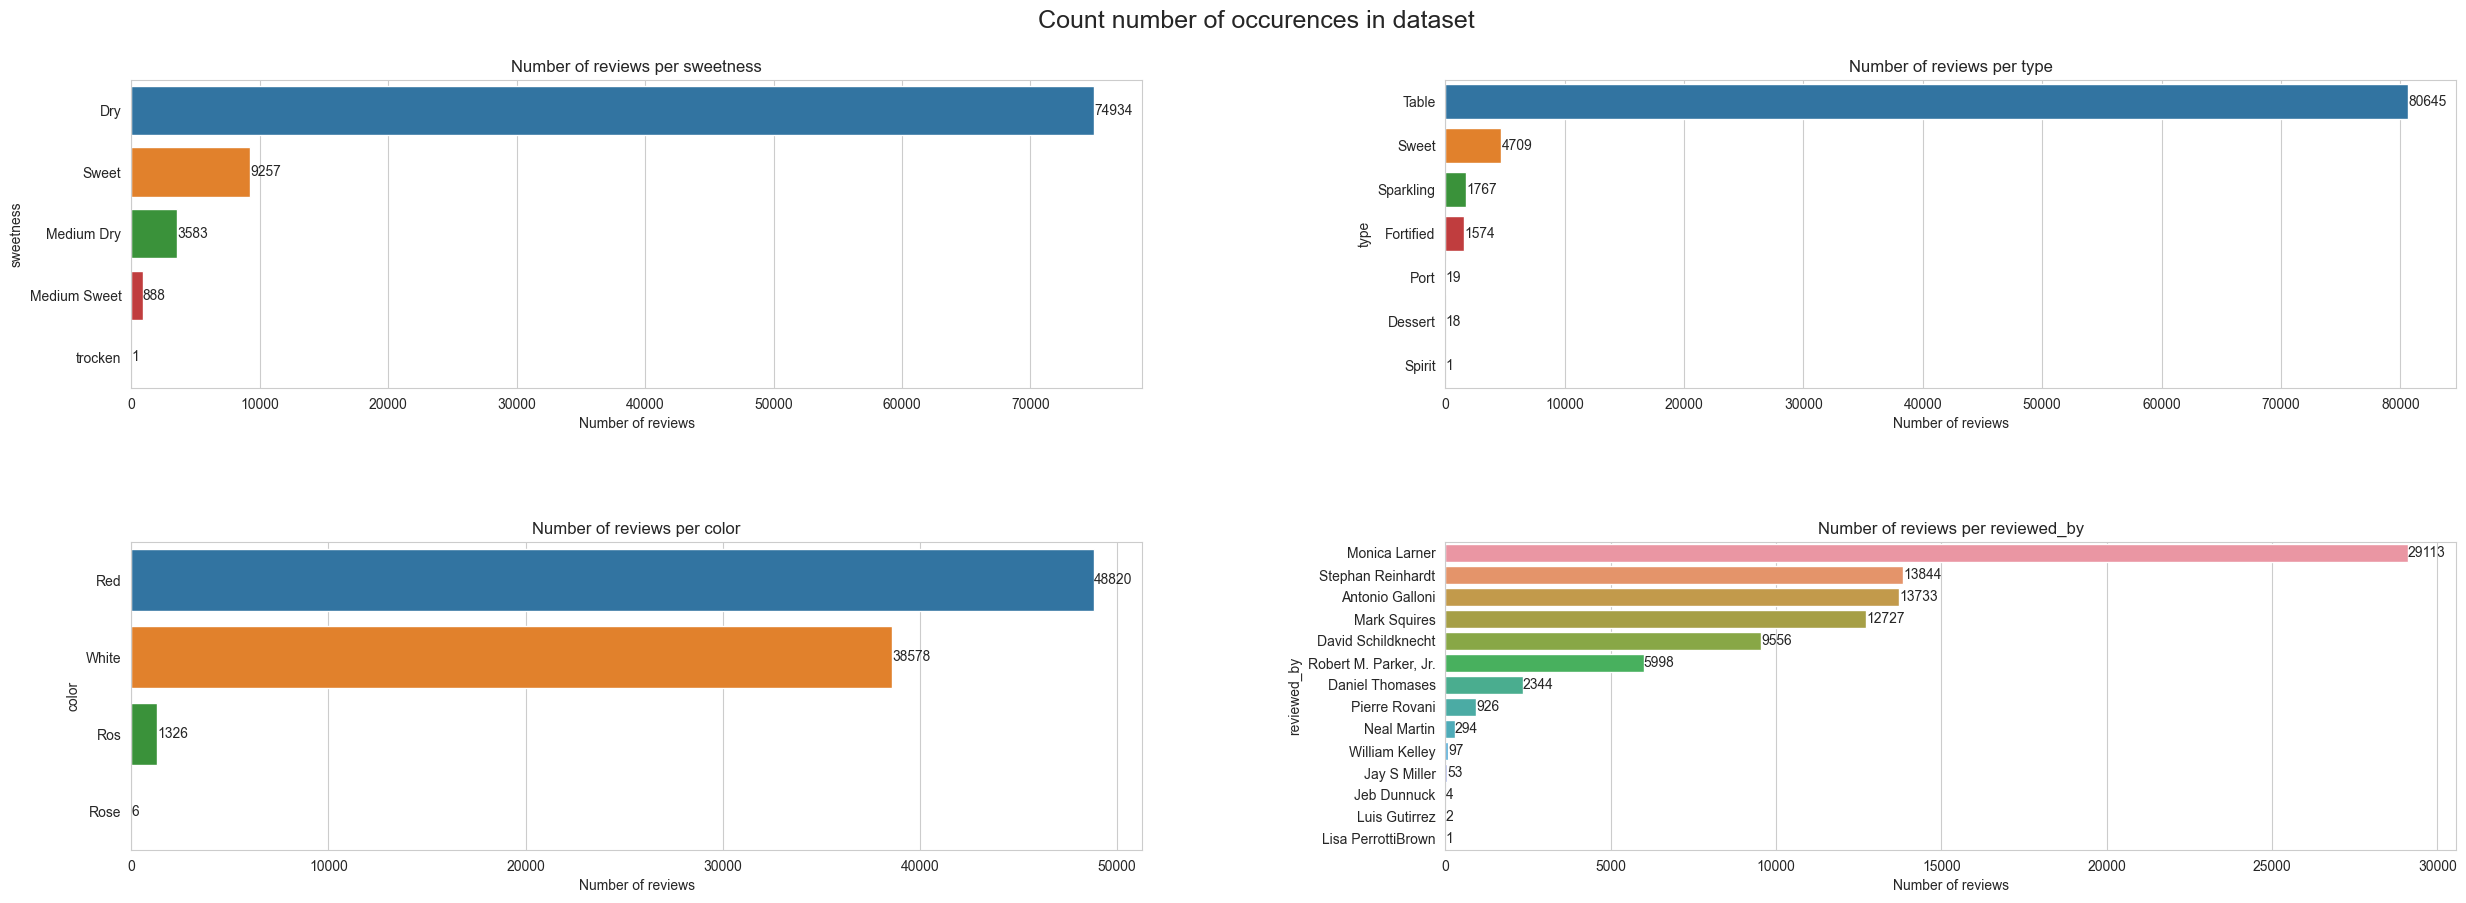

In [258]:
plot_features = ['sweetness', 'type', 'color', 'reviewed_by']

plot_rows = int(len(plot_features)/2)

fig, axs = plt.subplots(nrows=plot_rows, ncols=2, figsize=(30,10))
fig.suptitle("Count number of occurences in dataset", fontsize=18, y=0.95)
plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.3)

for feature, ax in zip(plot_features, axs.ravel()):

    ax = sns.countplot(data=df, y=feature, order=df[feature].value_counts().index, ax=ax)
    ax.bar_label(ax.containers[0])
    ax.set_title(f'Number of reviews per {feature}')
    ax.set_xlabel(f'Number of reviews')
    ax.set_ylabel(f'{feature}')
plt.savefig('data_exploration_categorical_occurences.png')
plt.show()



In [256]:
df.isna().sum()

title             0
rating           51
drink_date        0
reviewed_by      51
issue_date        0
source           51
content          95
producer          0
from_location     0
color            13
type             10
sweetness        80
variety           0
dtype: int64

# Data preparation

In [180]:
df.color.unique()

array(['White', 'Ros', 'Red', 'Rose', nan], dtype=object)

In [114]:
df.color.replace(to_replace='Ros', value='Rose', inplace=True)

In [182]:
df.color.unique()

array(['White', 'Rose', 'Red', nan], dtype=object)

In [183]:
df.isna().sum()

title             0
rating           51
drink_date        0
reviewed_by      51
issue_date        0
source           51
content          95
producer          0
from_location     0
color            13
type             10
sweetness        80
variety           0
dtype: int64

## Remove rows with missing values for 'rating', 'reviewed_by', 'source', 'color', 'type', 'sweetness'

In [115]:
cols = ['rating', 'reviewed_by', 'source', 'color', 'type', 'sweetness']
for col in cols:
    print(f'Number of rows in the {col} column with missing values: {df[col].isnull().sum()}') 
    #print(f'The rows are: {df.loc[df.col.isnull()]}')
    print(f'Current number of rows in DF: {len(df.index)}')
    df.dropna(axis=0, inplace=True, subset=[col])
    print(f'New number of rows in DF: {len(df.index)}')

Number of rows in the rating column with missing values: 0
Current number of rows in DF: 88524
New number of rows in DF: 88524
Number of rows in the reviewed_by column with missing values: 0
Current number of rows in DF: 88524
New number of rows in DF: 88524
Number of rows in the source column with missing values: 0
Current number of rows in DF: 88524
New number of rows in DF: 88524
Number of rows in the color column with missing values: 0
Current number of rows in DF: 88524
New number of rows in DF: 88524
Number of rows in the type column with missing values: 0
Current number of rows in DF: 88524
New number of rows in DF: 88524
Number of rows in the sweetness column with missing values: 0
Current number of rows in DF: 88524
New number of rows in DF: 88524


In [185]:
df.isna().sum()

title             0
rating            0
drink_date        0
reviewed_by       0
issue_date        0
source            0
content          44
producer          0
from_location     0
color             0
type              0
sweetness         0
variety           0
dtype: int64

In [116]:
def clean_rating(rating):
    """ """
    # Some ratings consists of multiple ratings in one, for example: (86 - 88)+
    # Take the average of the ratings in the "tuple" (actually it's a string)

    if rating.startswith("("):
        
        ratings_from_string = (float, re.findall(r'\d+', rating))[1] # Get all integers from the string in a list
        ratings_from_string = [float(x) for x in ratings_from_string]
        average = sum(ratings_from_string) / len(ratings_from_string)
        print(f'Replaced {rating} with {average}') # For auditting the changes to data - these changes will be printed
        rating = str(average) # Replace the "tuple" with the average of the ratings in it

    
    rating = re.sub(r"[^\d\.]","",rating) # Remove non-digit characters

    if rating == "": # Skip created empty elements after removing non-digit characters
        return None
    rating = float(rating) # Change type to float
    return rating

In [117]:
df['rating_cleaned'] = df['rating'].apply(clean_rating)

Replaced (95 - 97) with 96.0
Replaced (95 - 97) with 96.0
Replaced (94 - 96) with 95.0
Replaced (95 - 97) with 96.0
Replaced (94 - 96) with 95.0
Replaced (95 - 97) with 96.0
Replaced (96 - 98) with 97.0
Replaced (95 - 97) with 96.0
Replaced (94 - 96) with 95.0
Replaced (94 - 97) with 95.5
Replaced (93 - 95) with 94.0
Replaced (96 - 98) with 97.0
Replaced (94 - 96) with 95.0
Replaced (97 - 99) with 98.0
Replaced (92 - 94) with 93.0
Replaced (91 - 93) with 92.0
Replaced (87 - 89) with 88.0
Replaced (94 - 96) with 95.0
Replaced (95 - 97) with 96.0
Replaced (94 - 97) with 95.5
Replaced (87 - 89)? with 88.0
Replaced (95 - 97) with 96.0
Replaced (91 - 93) with 92.0
Replaced (88 - 90) with 89.0
Replaced (87 - 89) with 88.0
Replaced (92 - 94) with 93.0
Replaced (92 - 94) with 93.0
Replaced (87 - 89)? with 88.0
Replaced (89 - 91) with 90.0
Replaced (89 - 91) with 90.0
Replaced (90 - 92) with 91.0
Replaced (87 - 89) with 88.0
Replaced (94 - 96) with 95.0
Replaced (97 - 99) with 98.0
Replaced (94

## Remove rows without rating_cleaned

In [118]:
print(f'Number of rows in the rating_cleaned column without a rating_cleaned: {df["rating_cleaned"].isnull().sum()}') 
#print(f'The rows are: {df.loc[df.rating.isnull()]}')
print(f'Current number of rows in DF: {len(df.index)}')
df.dropna(axis=0, inplace=True, subset=['rating_cleaned'])
print(f'New number of rows in DF: {len(df.index)}')


Number of rows in the rating_cleaned column without a rating_cleaned: 0
Current number of rows in DF: 88524
New number of rows in DF: 88524


## Add new columns: 
- length of content
- vintage (from title)

In [119]:
df['length_content'] = df['content'].str.len()

regex = re.compile("^(\d{4})")
df['vintage'] = df['title'].str.extract(regex)

print(df.shape)
df.head(2)

(88524, 16)


title rating   drink_date    reviewed_by   
0   NV Acinum • Prosecco Extra Dry     87   2021  2022  Monica Larner  \
1  NV Acinum • Rosé Sparkling Wine     86   2021  2022  Monica Larner   

       issue_date                                   source   
0   16th Dec 2021  December 2021 Week 2, The Wine Advocate  \
1   16th Dec 2021  December 2021 Week 2, The Wine Advocate   

                                             content producer   
0  From the large Prosecco DOP appellation, the A...   Acinum  \
1  Showing a pale and delicate pink color, the Ac...   Acinum   

             from_location  color       type sweetness            variety   
0  Italy, Veneto, Prosecco  White  Sparkling       Dry              Glera  \
1  Italy, Vino Spumante VS   Rose  Sparkling       Dry  Proprietary Blend   

   rating_cleaned  length_content vintage  
0            87.0           323.0     NaN  
1            86.0           551.0     NaN

In [120]:
print(f'Number of rows in the lenth_content column without a value: {df.length_content.isnull().sum()}') 
#print(f'The rows are: {df.loc[df.length_content.isnull()]}')
print(f'Current number of rows in DF: {len(df.index)}')
df.length_content.fillna(value=0, inplace=True)
print(f'Number of rows in the lenth_content column without a value: {df.length_content.isnull().sum()}') 
print(f'New number of rows in DF: {len(df.index)}')


Number of rows in the lenth_content column without a value: 44
Current number of rows in DF: 88524
Number of rows in the lenth_content column without a value: 0
New number of rows in DF: 88524


## Vintage
- Remove rows without a vintage
- Set type to int
- Check where vintage != 4 numbers

In [121]:
print(f'Number of rows in the vintage column without a vintange: {df["vintage"].isnull().sum()}')
print(f'Current number of rows in DF: {len(df.index)}')
df.dropna(axis=0, inplace=True, subset=['vintage'])
print(f'New number of rows in DF: {len(df.index)}')


Number of rows in the vintage column without a vintange: 894
Current number of rows in DF: 88524
New number of rows in DF: 87630


In [122]:
df['vintage'] = df['vintage'].astype('int') # set type of vintage to int

In [123]:
df['length_vintage'] = df['vintage'].astype(str).str.len() # create column for the length of vintage
print(f'Number of rows where vintage is not 4 numbers: {df.length_vintage[df["length_vintage"] == 0].count()}')

Number of rows where vintage is not 4 numbers: 0


### Extract country, region, location and location_extra from "from_location" field

In [124]:
location_vars = ['country', 'region', 'sub_region', 'appellation', 'sub_appellation']
df_splitted = df['from_location'].str.split(",", expand=True)


for x in df_splitted:
    df[location_vars[x]] = df_splitted[x]
df.head(2)

title rating   drink_date   
372  2021 Abbazia di Novacella • Alto Adige Pinot Nero     90   2022  2026  \
373  2021 Abbazia di Novacella • Alto Adige Valle I...     91   2022  2026   

       reviewed_by     issue_date                                   source   
372  Monica Larner   8th Dec 2022  December 2022 Week 1, The Wine Advocate  \
373  Monica Larner   8th Dec 2022  December 2022 Week 1, The Wine Advocate   

                                               content              producer   
372  A young and vibrant expression of the Burgundi...  Abbazia di Novacella  \
373  The Abbazia di Novacella 2021 Alto Adige Valle...  Abbazia di Novacella   

                                         from_location  color  ...   
372              Italy, TrentinoAlto Adige, Alto Adige    Red  ...  \
373  Italy, TrentinoAlto Adige, Alto Adige Valle Is...  White  ...   

             variety rating_cleaned length_content  vintage  length_vintage   
372       Pinot Noir           90.0          535.0     2021               4  \
373  Grner Veltliner           91.0          421.0     2021               4   

     country               region                sub_region appellation   
372    Italy   TrentinoAlto Adige                Alto Adige        None  \
373    Italy   TrentinoAlto Adige   Alto Adige Valle Isarco        None   

    sub_appellation  
372            None  
373            None  

[2 rows x 22 columns]

## Extract wine name from title

In [125]:
regex = re.compile(r'\•(.+)')
df['name'] = df['title'].str.extract(regex)
print(f'Number of rows with empty name: { df.name.isna().sum()} ')
df.head(2)

Number of rows with empty name: 0 


title rating   drink_date   
372  2021 Abbazia di Novacella • Alto Adige Pinot Nero     90   2022  2026  \
373  2021 Abbazia di Novacella • Alto Adige Valle I...     91   2022  2026   

       reviewed_by     issue_date                                   source   
372  Monica Larner   8th Dec 2022  December 2022 Week 1, The Wine Advocate  \
373  Monica Larner   8th Dec 2022  December 2022 Week 1, The Wine Advocate   

                                               content              producer   
372  A young and vibrant expression of the Burgundi...  Abbazia di Novacella  \
373  The Abbazia di Novacella 2021 Alto Adige Valle...  Abbazia di Novacella   

                                         from_location  color  ...   
372              Italy, TrentinoAlto Adige, Alto Adige    Red  ...  \
373  Italy, TrentinoAlto Adige, Alto Adige Valle Is...  White  ...   

    rating_cleaned length_content vintage  length_vintage  country   
372           90.0          535.0    2021               4    Italy  \
373           91.0          421.0    2021               4    Italy   

                  region                sub_region appellation   
372   TrentinoAlto Adige                Alto Adige        None  \
373   TrentinoAlto Adige   Alto Adige Valle Isarco        None   

    sub_appellation                                       name  
372            None                      Alto Adige Pinot Nero  
373            None   Alto Adige Valle Isarco Grüner Veltliner  

[2 rows x 23 columns]

## Remove unnecessary column: title, rating, issue_date, source and length_vintage and from_location

In [126]:
df.drop(labels=['title', 'rating','issue_date', 'source', 'length_vintage', 'from_location'], axis=1, inplace=True)
print(df.shape)
df.head(2)

(87630, 17)


drink_date    reviewed_by   
372   2022  2026  Monica Larner  \
373   2022  2026  Monica Larner   

                                               content              producer   
372  A young and vibrant expression of the Burgundi...  Abbazia di Novacella  \
373  The Abbazia di Novacella 2021 Alto Adige Valle...  Abbazia di Novacella   

     color   type sweetness          variety  rating_cleaned  length_content   
372    Red  Table       Dry       Pinot Noir            90.0           535.0  \
373  White  Table       Dry  Grner Veltliner            91.0           421.0   

     vintage country               region                sub_region   
372     2021   Italy   TrentinoAlto Adige                Alto Adige  \
373     2021   Italy   TrentinoAlto Adige   Alto Adige Valle Isarco   

    appellation sub_appellation                                       name  
372        None            None                      Alto Adige Pinot Nero  
373        None            None   Alto Adige Valle Isarco Grüner Veltliner

## Describe, types and unique values per column

In [127]:
df.isna().sum()

drink_date             0
reviewed_by            0
content               44
producer               0
color                  0
type                   0
sweetness              0
variety                0
rating_cleaned         0
length_content         0
vintage                0
country                0
region               887
sub_region         40130
appellation        80361
sub_appellation    86060
name                   0
dtype: int64

In [128]:
df.describe()

rating_cleaned  length_content       vintage
count    87630.000000    87630.000000  87630.000000
mean        89.996845      737.406870   2010.296622
std          3.045296      631.444456      8.363308
min         15.000000        0.000000   1760.000000
25%         88.000000      408.000000   2007.000000
50%         90.000000      536.000000   2011.000000
75%         92.000000      787.000000   2016.000000
max        100.000000     7380.000000   2022.000000

In [199]:
df.dtypes

drink_date          object
reviewed_by         object
content             object
producer            object
color               object
type                object
sweetness           object
variety             object
rating_cleaned     float64
length_content     float64
vintage              int32
country             object
region              object
sub_region          object
appellation         object
sub_appellation     object
name                object
dtype: object

Unique values

In [129]:
for i in df.columns:
    #print(f'Unique values in {i} column: {df[i].unique()}') # The unique values itself
    print(f'Number of unique values in {i} column: {df[i].nunique()}') # The number of unique values per column

Number of unique values in drink_date column: 1198
Number of unique values in reviewed_by column: 13
Number of unique values in content column: 86616
Number of unique values in producer column: 4462
Number of unique values in color column: 3
Number of unique values in type column: 7
Number of unique values in sweetness column: 4
Number of unique values in variety column: 421
Number of unique values in rating_cleaned column: 72
Number of unique values in length_content column: 3803
Number of unique values in vintage column: 124
Number of unique values in country column: 3
Number of unique values in region column: 72
Number of unique values in sub_region column: 378
Number of unique values in appellation column: 101
Number of unique values in sub_appellation column: 168
Number of unique values in name column: 27724


# Visualizations

### Histogram of vintage

In [20]:
df.nunique()

drink_date          1198
reviewed_by           13
content            86616
producer            4462
color                  3
type                   7
sweetness              4
variety              421
rating_cleaned        72
length_content      3803
vintage              124
country                3
region                72
sub_region           378
appellation          101
sub_appellation      168
name               27724
dtype: int64

<Axes: xlabel='vintage', ylabel='Count'>

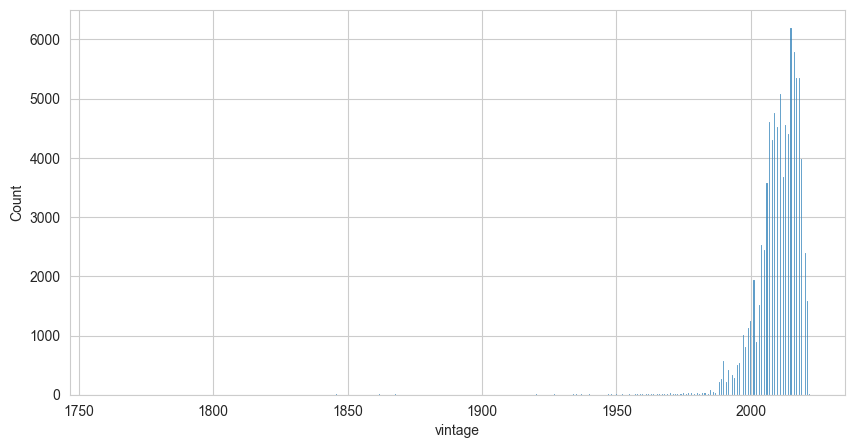

In [73]:
plt.figure(figsize=(10,5))
sns.histplot(data = df, x='vintage')

### Range of ratings by each reviewer

<Axes: xlabel='reviewed_by', ylabel='rating_cleaned'>

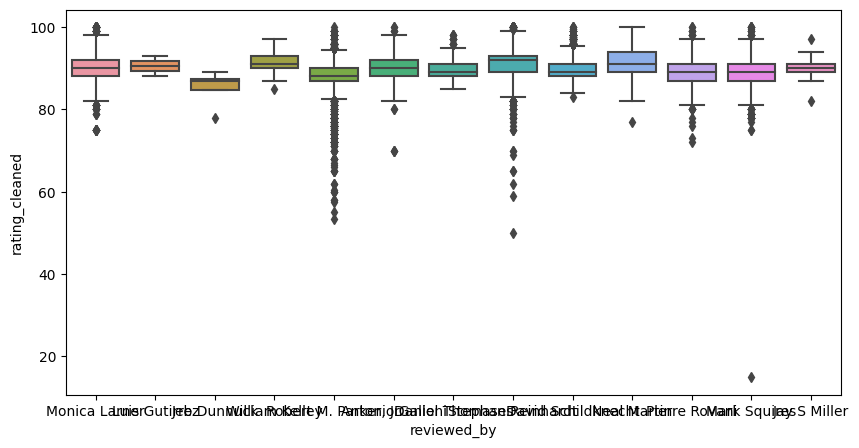

In [66]:
plt.figure(figsize=(10,5))
sns.boxplot(data = df, x='reviewed_by', y='rating_cleaned')

<Axes: xlabel='rating_cleaned', ylabel='Density'>

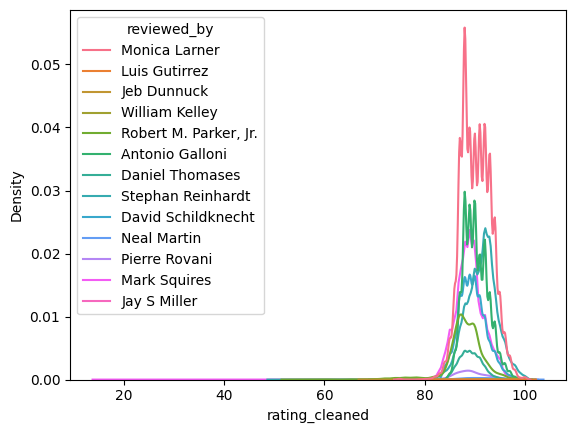

In [67]:
sns.kdeplot(data = df, x='rating_cleaned', hue='reviewed_by')

C:\Users\Lisanne\AppData\Local\Temp\ipykernel_170700\2346885787.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data = df, x='rating_cleaned', hue='vintage')


<Axes: xlabel='rating_cleaned', ylabel='Density'>

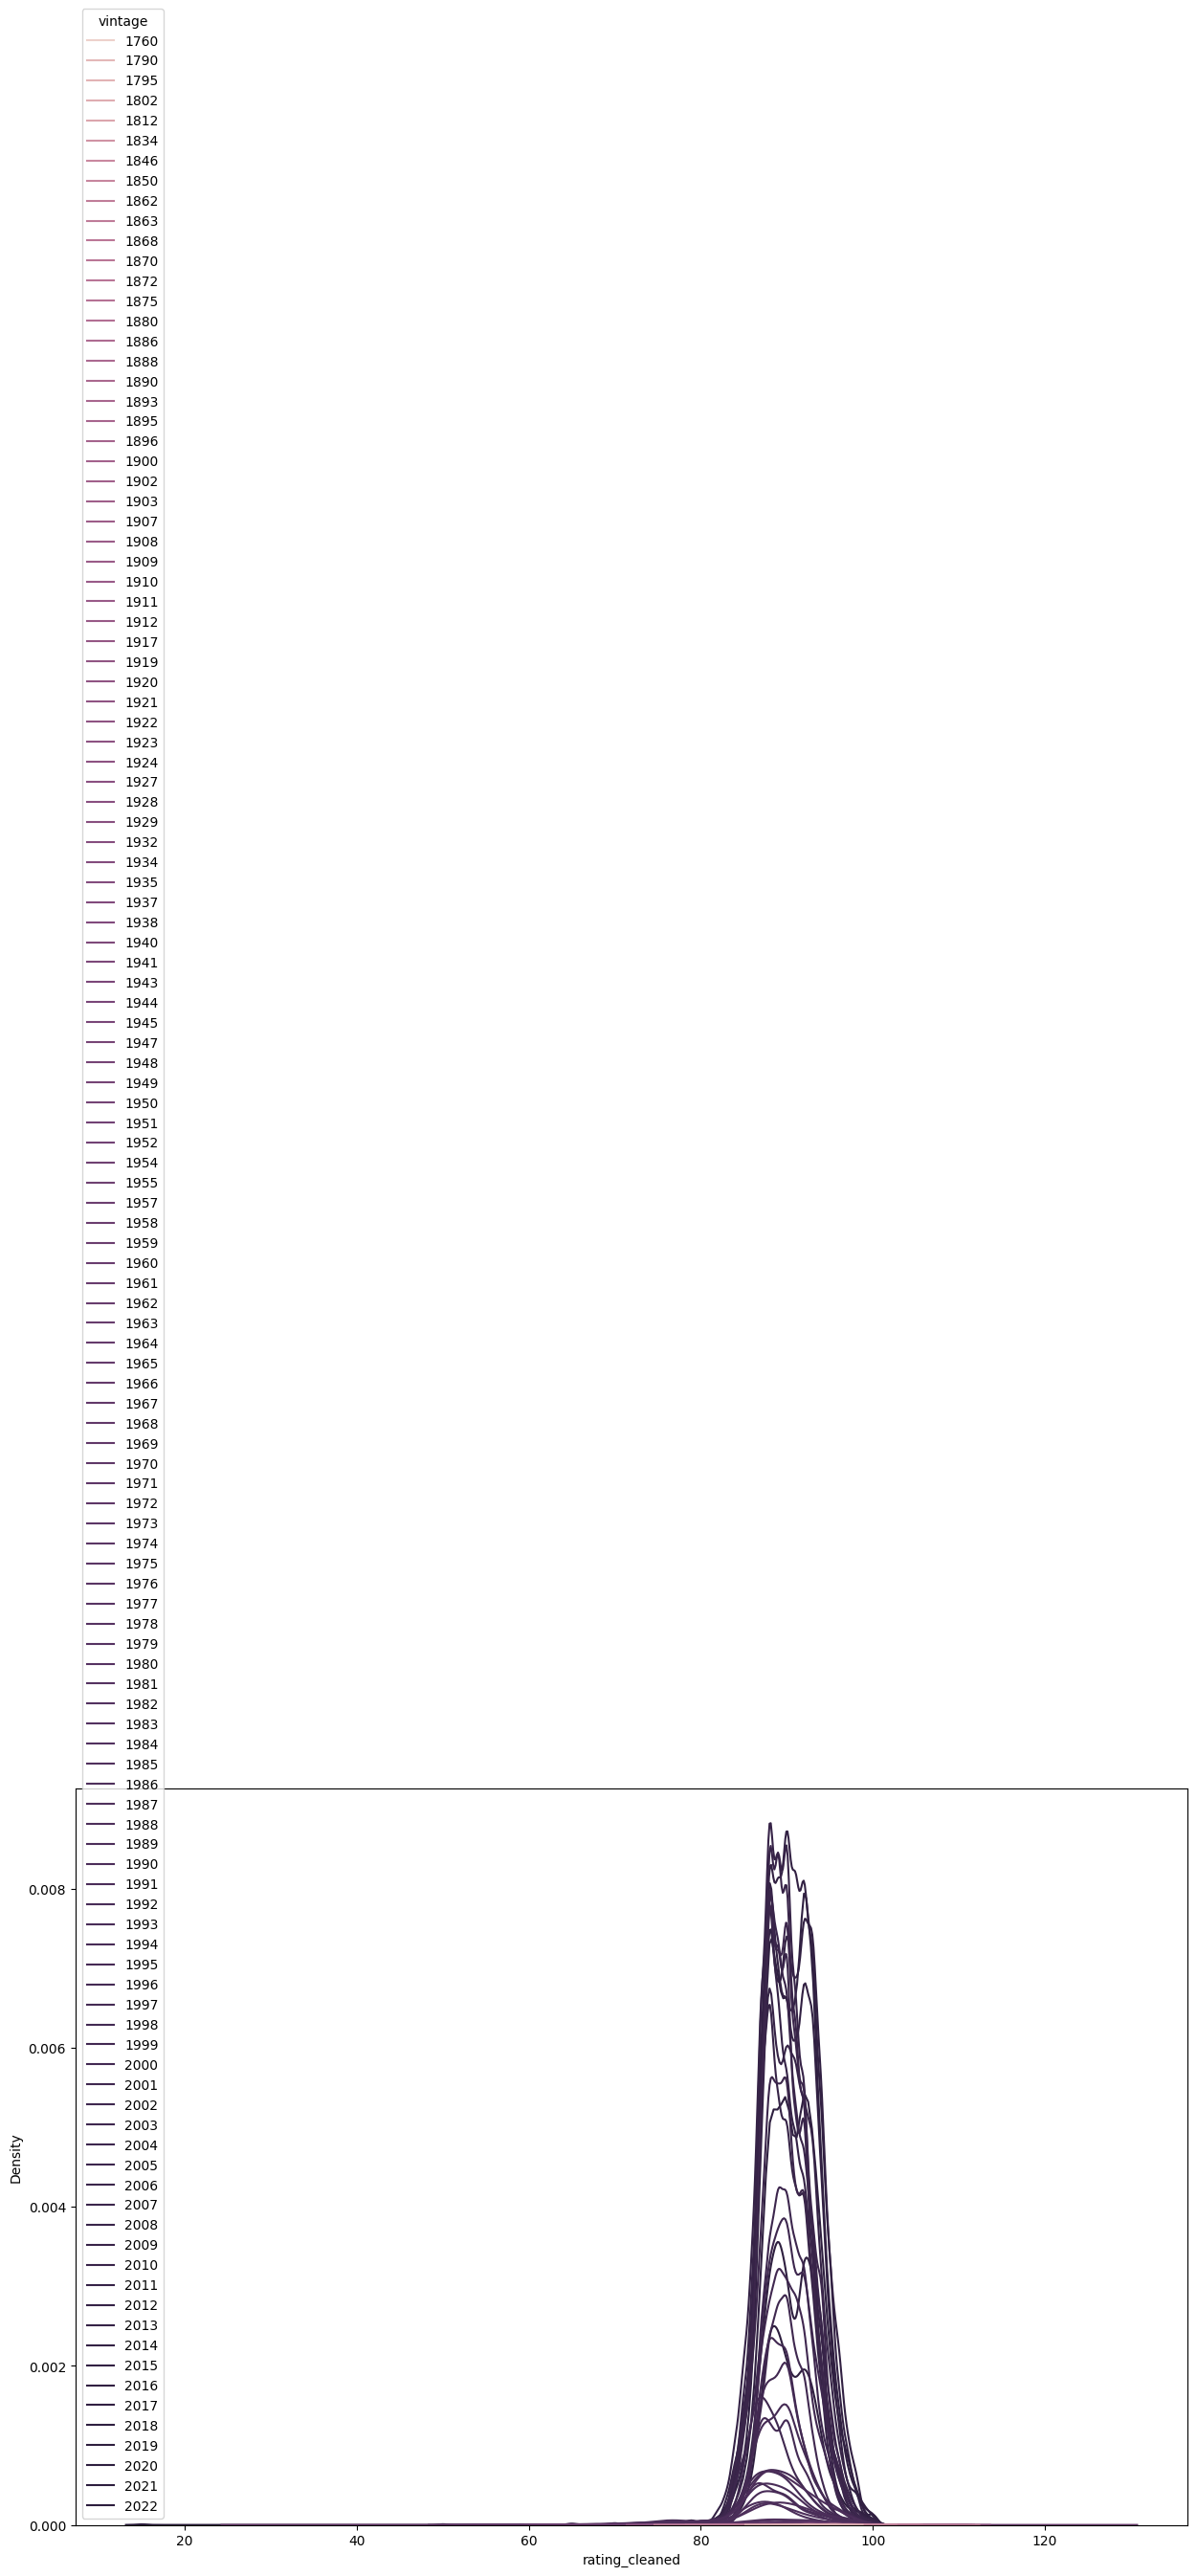

In [68]:
plt.figure(figsize=(15,10))
sns.kdeplot(data = df, x='rating_cleaned', hue='vintage')

## Distribution of Ratings per producer


C:\Users\Lisanne\AppData\Local\Temp\ipykernel_170700\3817416207.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data = df, x='rating_cleaned', hue='producer', legend=False)


<Axes: xlabel='rating_cleaned', ylabel='Density'>

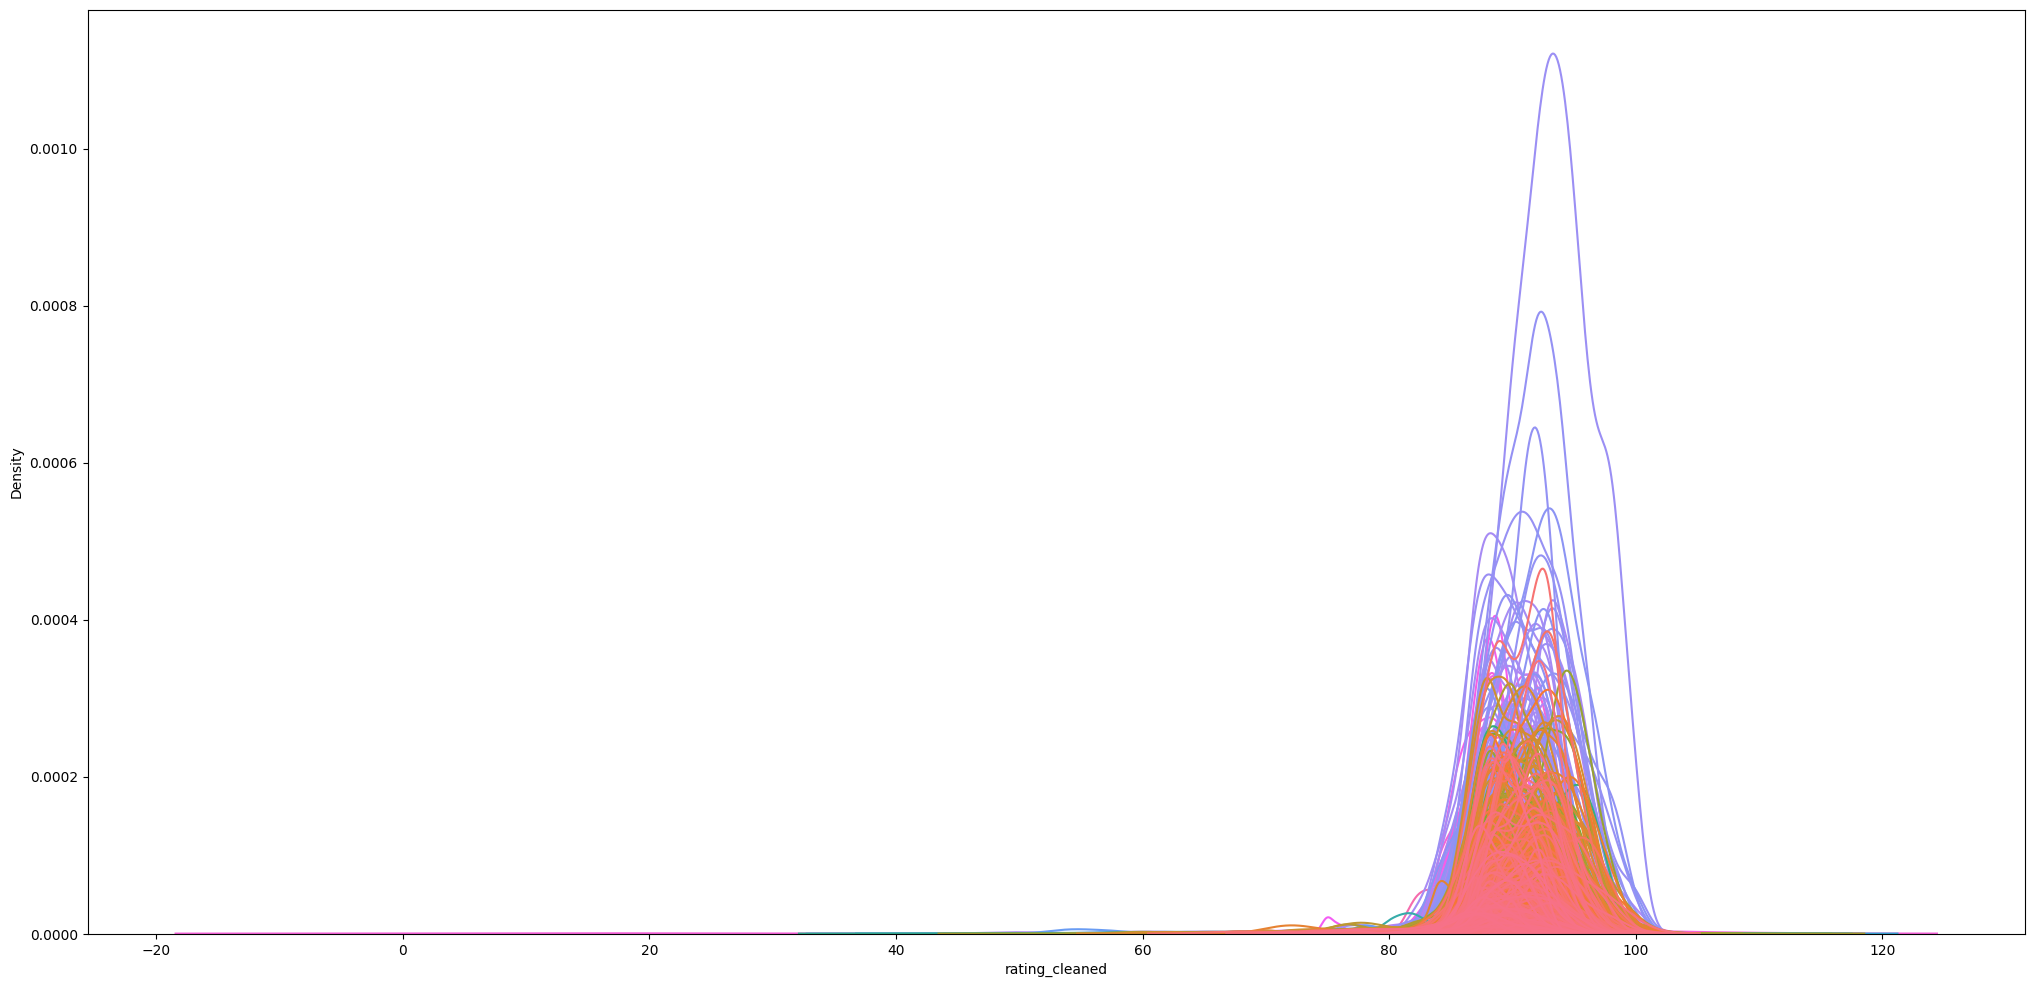

In [69]:
plt.figure(figsize=(25,12))
sns.kdeplot(data = df, x='rating_cleaned', hue='producer', legend=False)

## Histogram of ratings

<Axes: xlabel='rating_cleaned', ylabel='Count'>

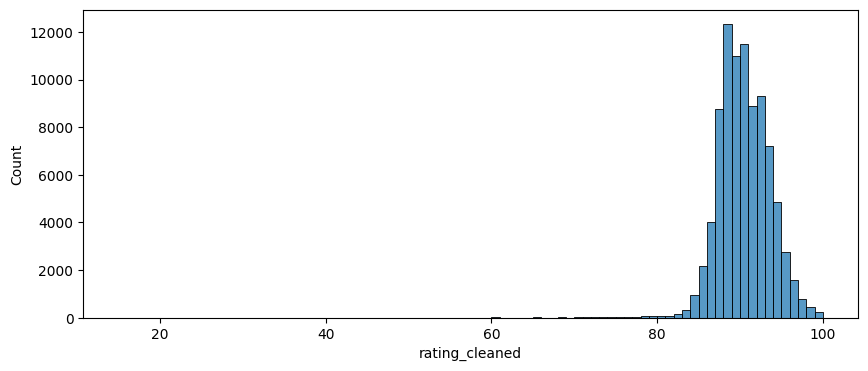

In [70]:
plt.figure(figsize=(10,4))
sns.histplot(data=df, x='rating_cleaned', stat='count', binwidth=1)



Looks like a pretty good normal distribution! Let's test to be sure. Important: range of reatings is high!

In [186]:
import statsmodels.api as sm
values = np.array(df.rating_cleaned)
result = sm.stats.diagnostic.lilliefors(values, dist='norm', pvalmethod='table')

print(f'Test statistic = {result[0]} \nP-value = {result[1]}')

Test statistic = 0.08733056872260059 
P-value = 0.0009999999999998899


Niet normaal verdeeld. p<0,05. 0 hypothese verwerpen.

<Axes: >

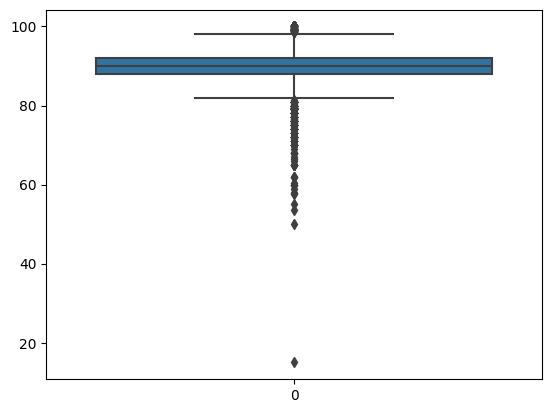

In [258]:
sns.boxplot(data=values)

In [22]:
df.nunique()

drink_date          1198
reviewed_by           13
content            86616
producer            4462
color                  3
type                   7
sweetness              4
variety              421
rating_cleaned        72
length_content      3803
vintage              124
country                3
region                72
sub_region           378
appellation          101
sub_appellation      168
name               27724
dtype: int64

Is de rating verschillend tussen de verschillende colors?

<Axes: xlabel='color', ylabel='rating_cleaned'>

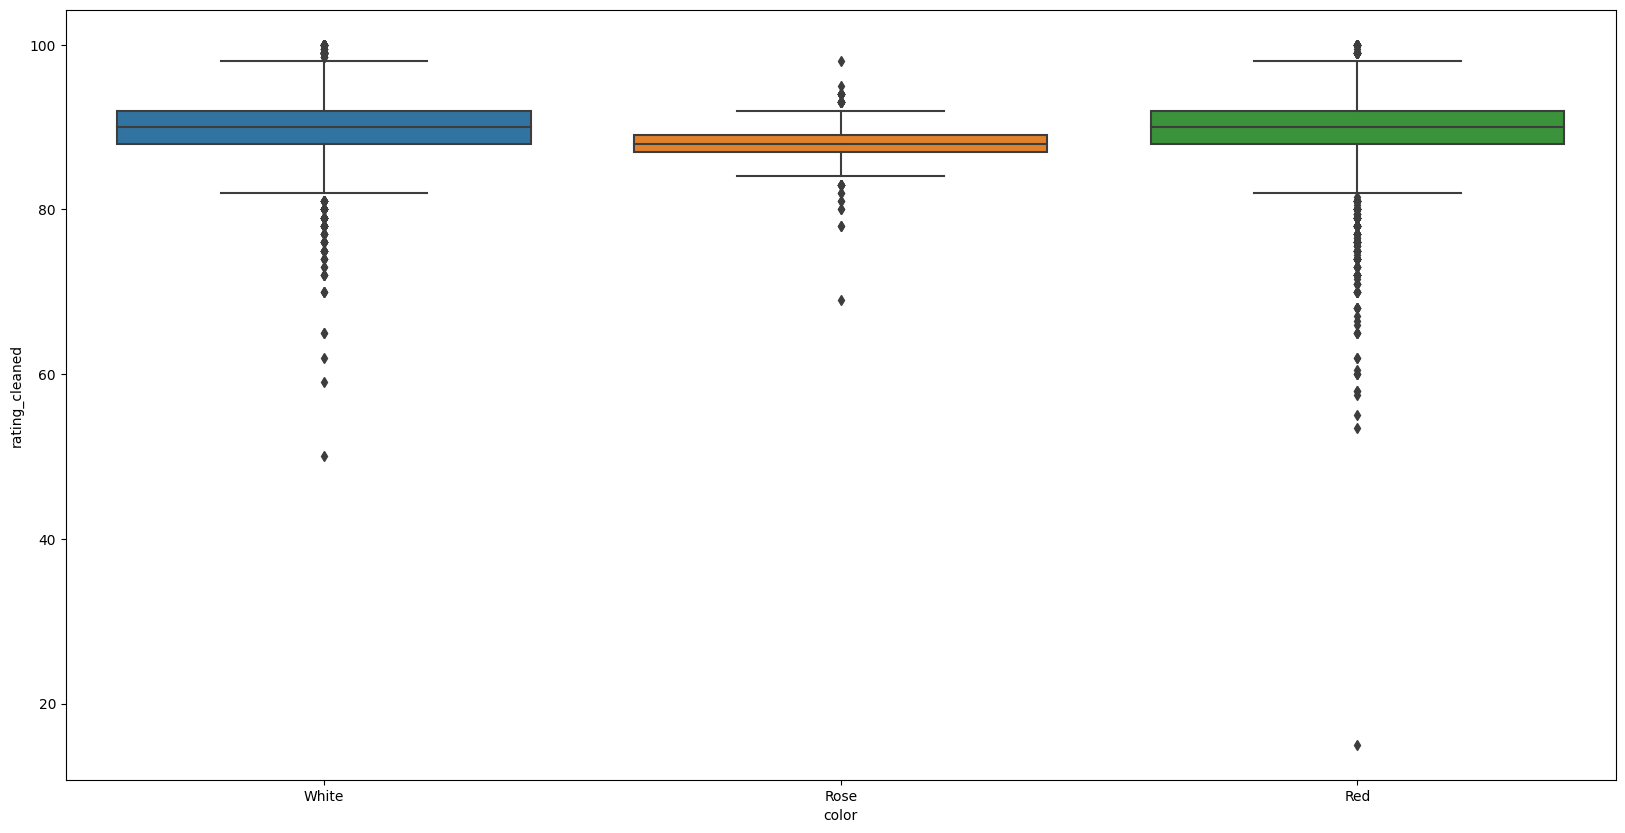

In [10]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df, x='color', y='rating_cleaned')

Op basis van de boxplot niet veel verschil te zien.

H0: The 3 colors are equal in terms of rating

H1: At least one color is different from the other 2 colors in terms of rating

In [199]:
from scipy.stats import chi2
from chart_studio import plotly as py
import plotly.graph_objects as go

In [244]:
def kruskal_wallis_test(test_df, num_field, cat_field, alpha):

	k = test_df[cat_field].nunique()
	N = test_df[cat_field].count()

	df = test_df.copy()

	df['rank'] = df[num_field]
	df['rank'] = df['rank'].rank(ascending=True)

	table1 = df.groupby(cat_field).sum()
	table2 = df.groupby(cat_field).count()

	sub_component = 0
	for i in range(0, k):
		sub_component = (table1.iloc[i, 1] ** 2 / table2.iloc[i, 1]) + sub_component

	test_statistic = ((12 / (N * (N + 1))) * sub_component) - 3 * (N + 1)
	degrees_of_freedom = k - 1
	a = alpha / 100
	chi_critical_value = round(chi2.isf(q=a, df=degrees_of_freedom), 2)
	p_value = chi2.sf(test_statistic, degrees_of_freedom, loc=0, scale=1)


	if(test_statistic >= chi_critical_value):
		result = 'reject null hypothesis - meaning there is difference'
		print(result)
	else:
		result = 'keep null hypothesis - meaning all the same'
		print(result)

	return (round(test_statistic,2), chi_critical_value,  p_value, a)


In [247]:
test_vars = ['color', 'type', 'reviewed_by', 'sweetness', 'producer', 'variety', 'vintage', 'appellation', 'country']
test_results = []

for var in test_vars:
	print(var)
	test_df = df[['rating_cleaned', var]]
	results = kruskal_wallis_test(test_df, num_field='rating_cleaned', cat_field=var, alpha=5)
	new_result = {'Variable':var, 'Test Statistic':results[0], 'Chi critical value':results[1], 'P-Value':results[2], 'Alpha': results[3]}
	test_results.append(new_result)

df_test_results = pd.DataFrame(test_results)
fig = go.Figure(data=[go.Table(header=dict(values=df_test_results.columns),
			cells=dict(values=[df_test_results['Variable'], df_test_results['Test Statistic'], df_test_results['Chi critical value'], df_test_results['P-Value'], df_test_results['Alpha']]))
			])
fig.show()

color
reject null hypothesis - meaning there is difference
type
reject null hypothesis - meaning there is difference
reviewed_by
reject null hypothesis - meaning there is difference
sweetness
reject null hypothesis - meaning there is difference
producer
reject null hypothesis - meaning there is difference
variety
reject null hypothesis - meaning there is difference
vintage
reject null hypothesis - meaning there is difference
appellation
reject null hypothesis - meaning there is difference
country
reject null hypothesis - meaning there is difference


In [237]:
df_test_results.columns

Index(['Variable', 'Test Statistic', 'Chi critical value', 'P-Value', 'Alpha'], dtype='object')

<Axes: xlabel='color', ylabel='rating_cleaned'>

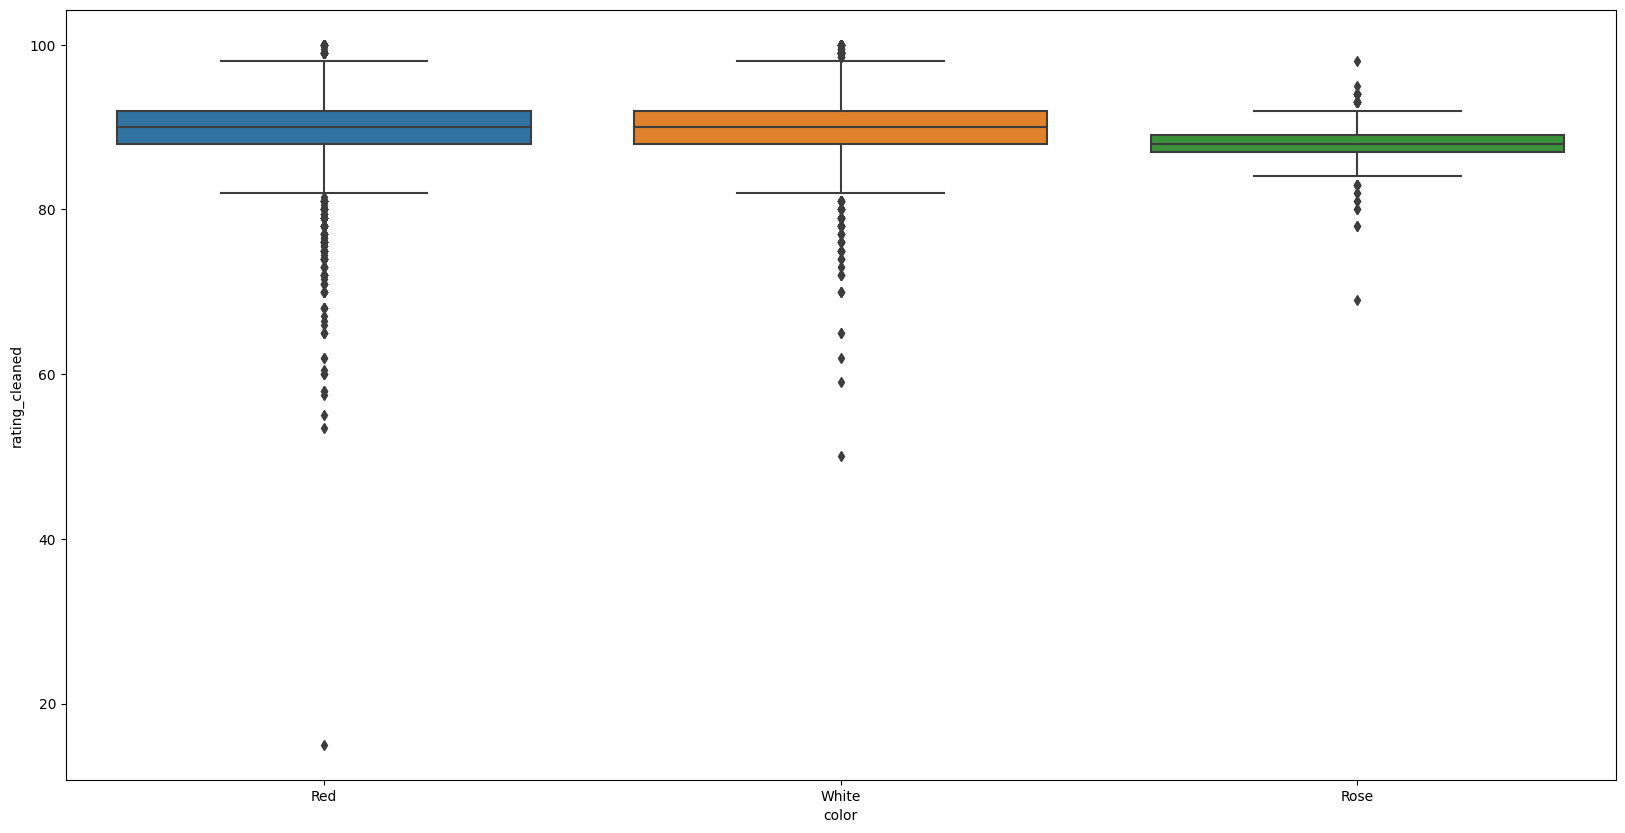

In [146]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df, x='color', y='rating_cleaned')

<Axes: xlabel='type', ylabel='rating_cleaned'>

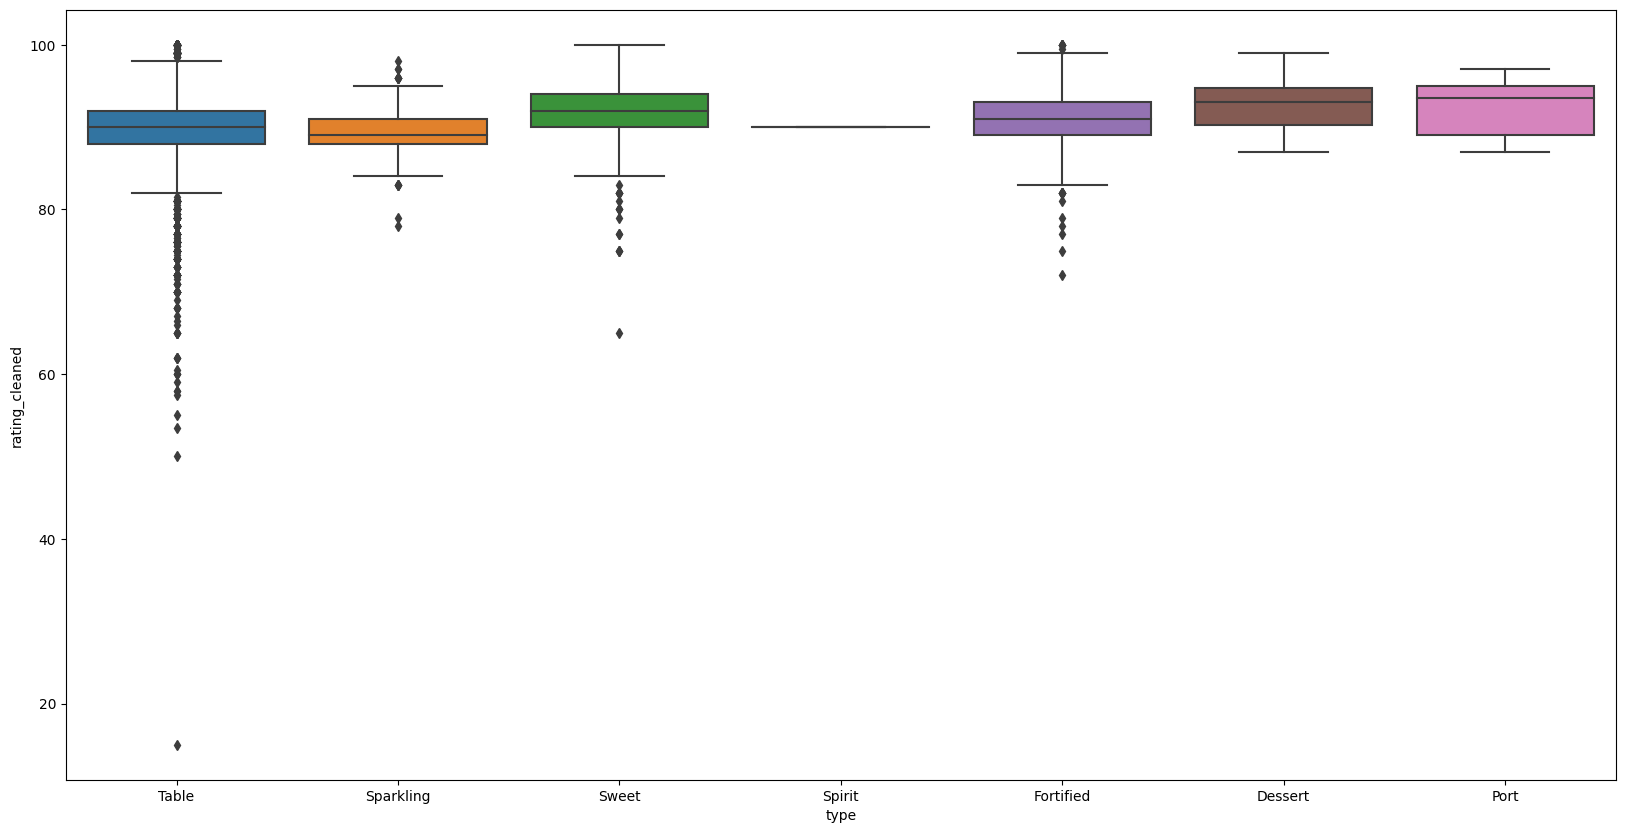

In [148]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df, x='type', y='rating_cleaned')

<Axes: xlabel='sweetness', ylabel='rating_cleaned'>

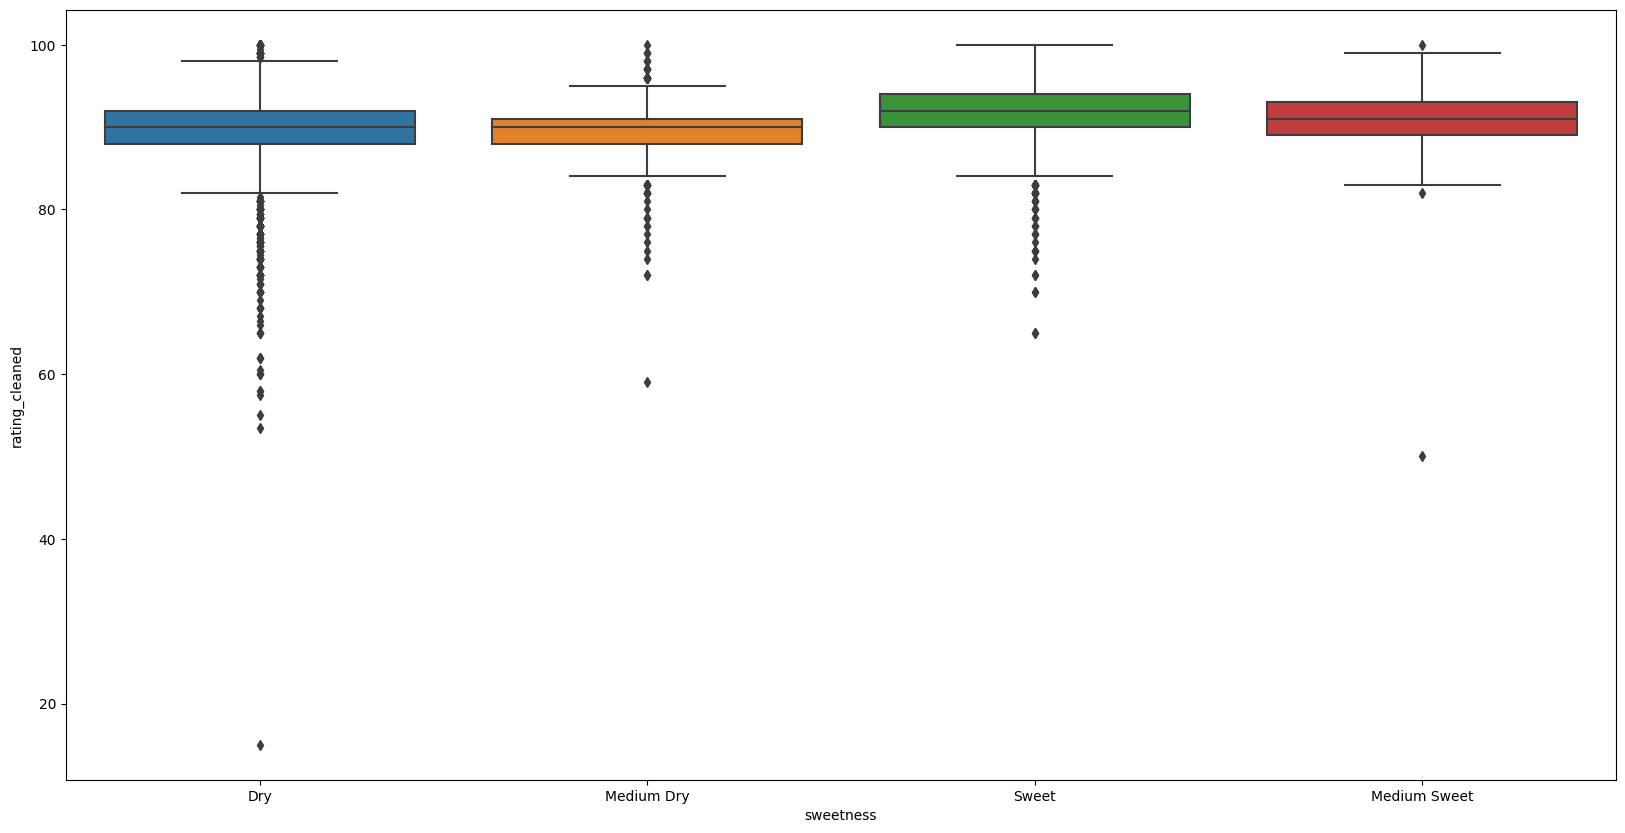

In [151]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df, x='sweetness', y='rating_cleaned')

<Axes: xlabel='producer', ylabel='rating_cleaned'>

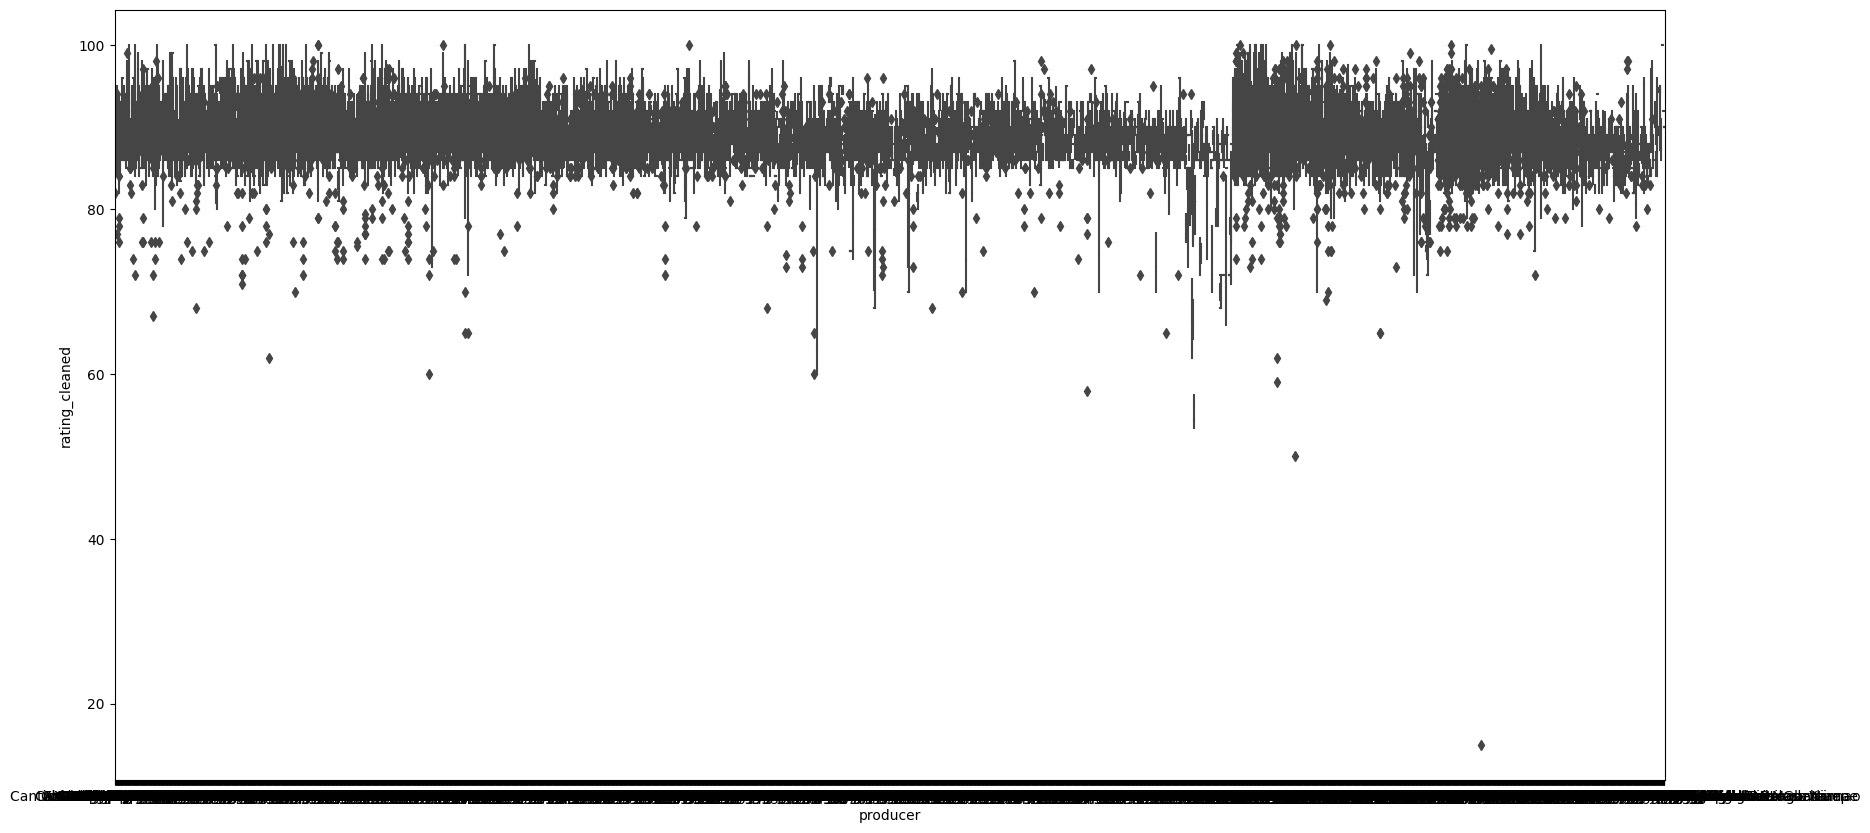

In [153]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df, x='producer', y='rating_cleaned')

<Axes: xlabel='variety', ylabel='rating_cleaned'>

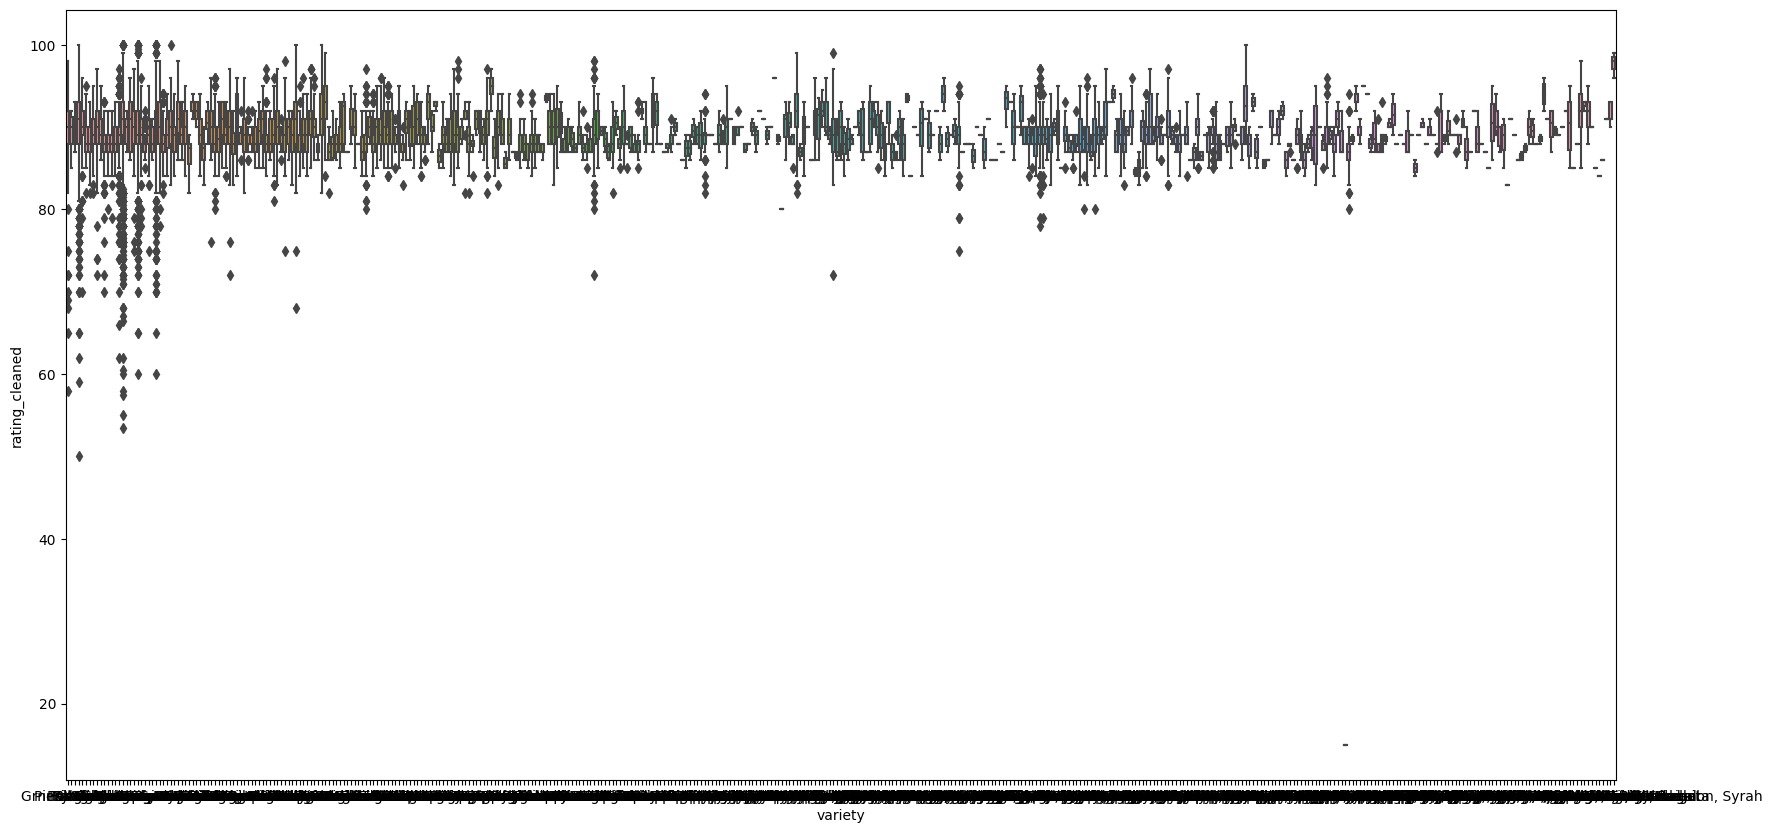

In [143]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df, x='variety', y='rating_cleaned')

<Axes: xlabel='country', ylabel='rating_cleaned'>

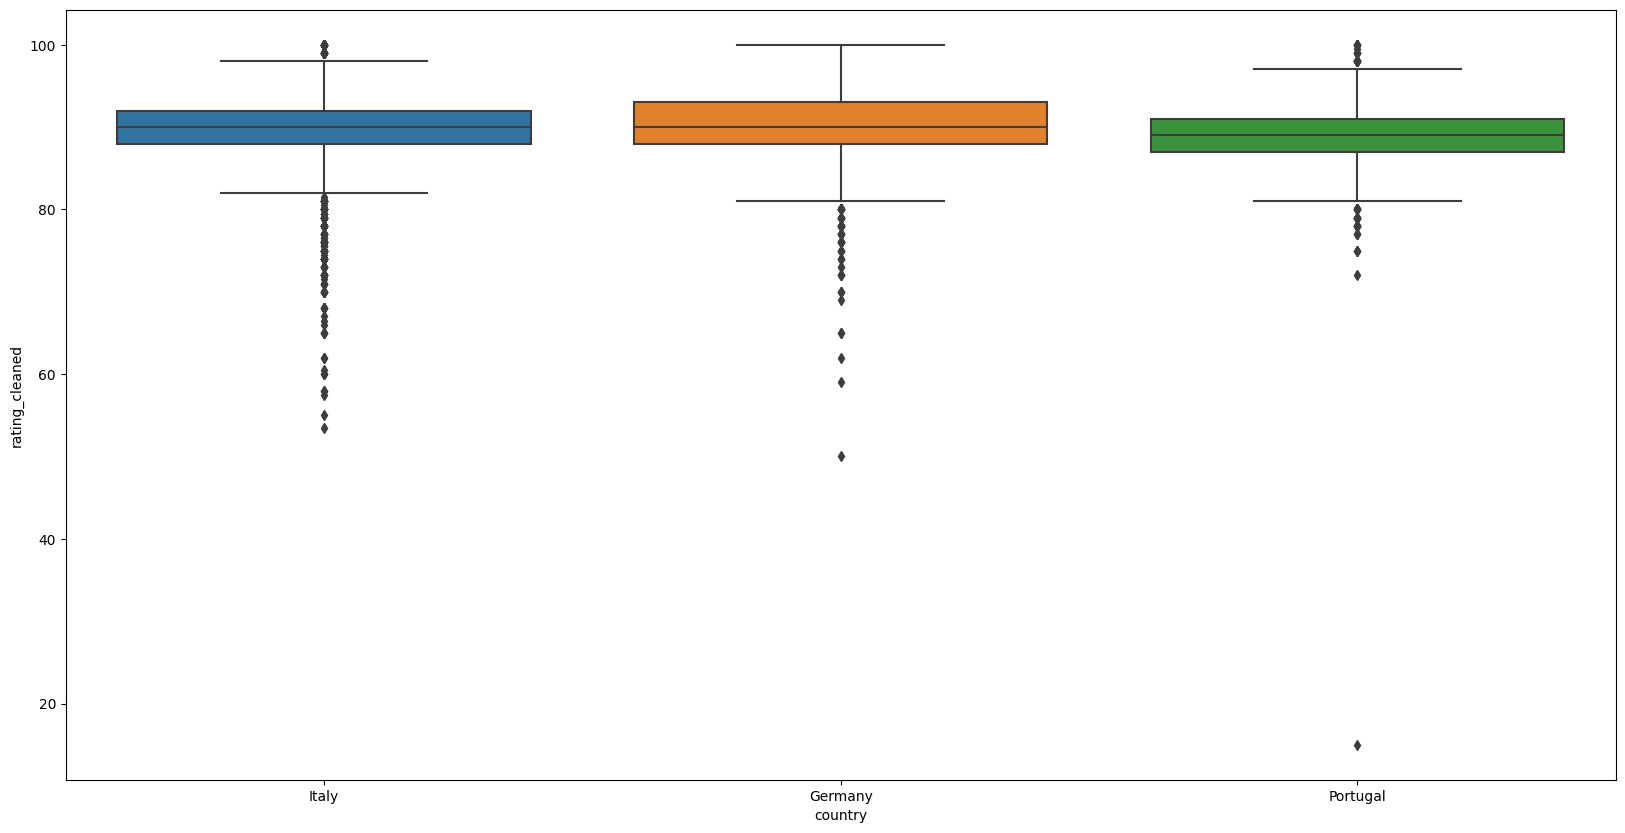

In [158]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df, x='country', y='rating_cleaned')

## Relation between length of content (description) and ratings

<Axes: xlabel='length_content', ylabel='rating_cleaned'>

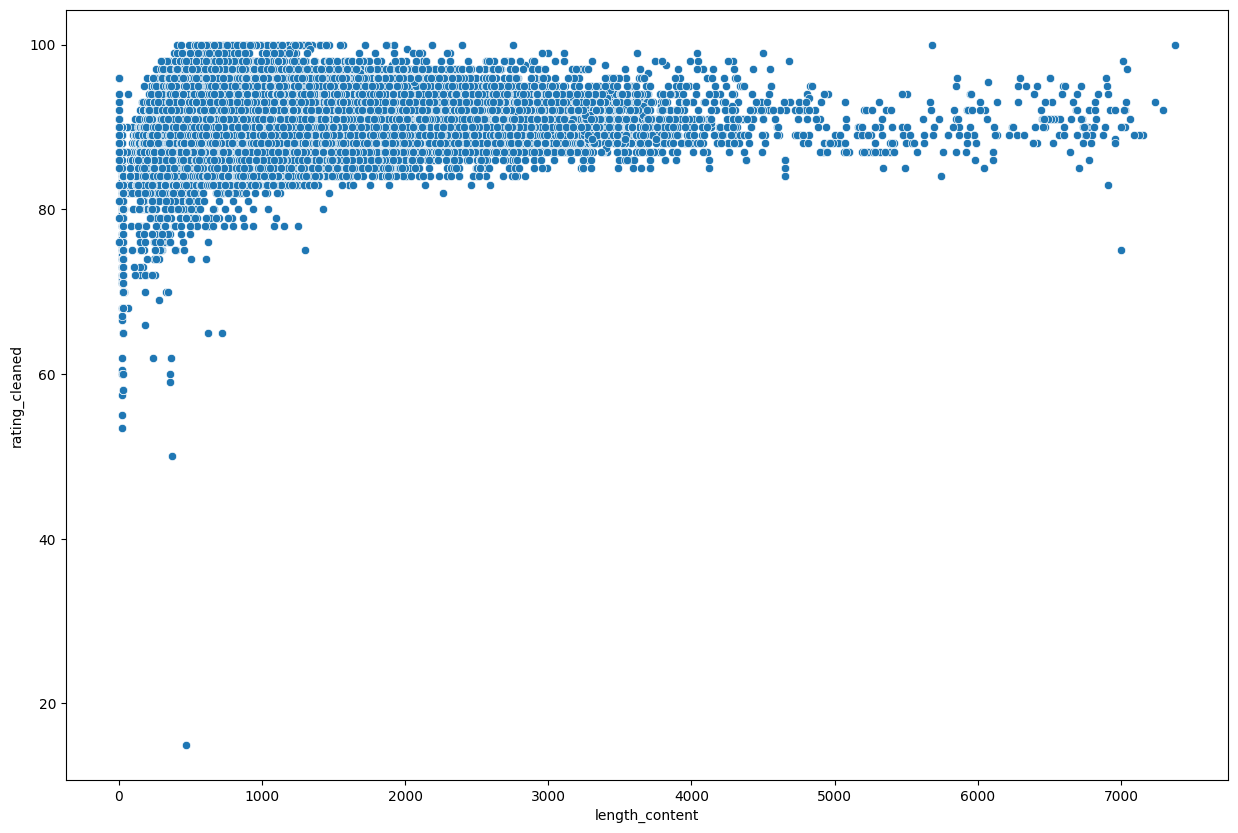

In [71]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=df, x='length_content', y='rating_cleaned')

## Average ratings over the years

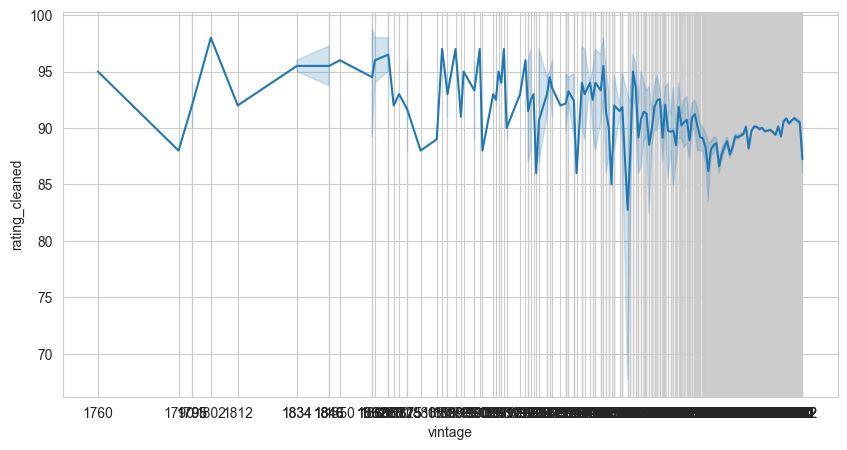

In [72]:
plt.figure(figsize=(10,5))
sns.set_style('whitegrid')
ax = sns.lineplot(data=df, x='vintage', y='rating_cleaned', estimator='mean', markers=True, dashes=True, err_style='band')
ax.set(xticks=df['vintage'].values)
plt.show()

## Median ratings over the years

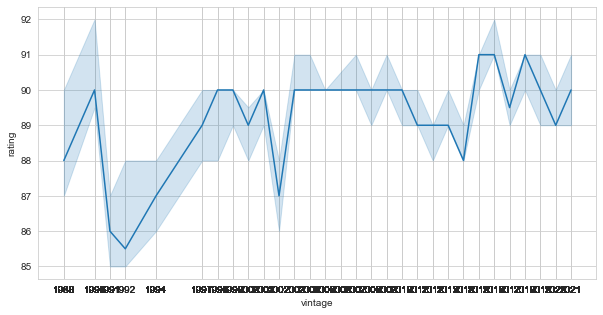

In [30]:
plt.figure(figsize=(10,5))
sns.set_style('white')
ax = sns.lineplot(data=df, x='vintage', y='rating_cleaned', estimator='median', markers=True, dashes=True, err_style='band')
ax.set(xticks=df['vintage'].values)
plt.show()

## Mean ratings over the years, by reviewer

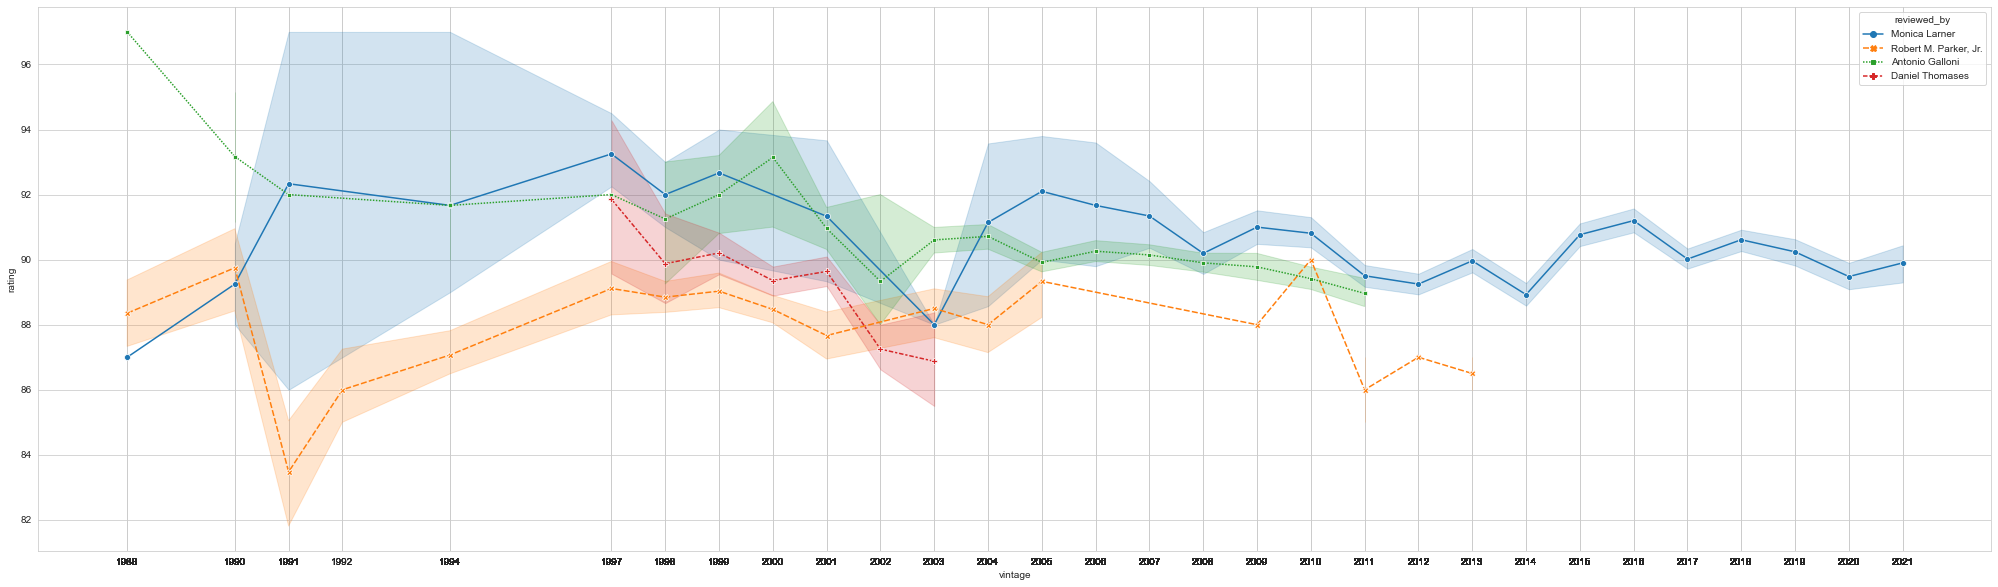

In [32]:
plt.figure(figsize=(35,10))
sns.set_style('whitegrid')
ax = sns.lineplot(data=df, x='vintage', y='rating_cleaned', hue='reviewed_by', estimator='mean', style='reviewed_by', markers=True, dashes=True, err_style='band')
ax.set(xticks=df['vintage'].values)
plt.show()

## Median rating over the years, by reviewer

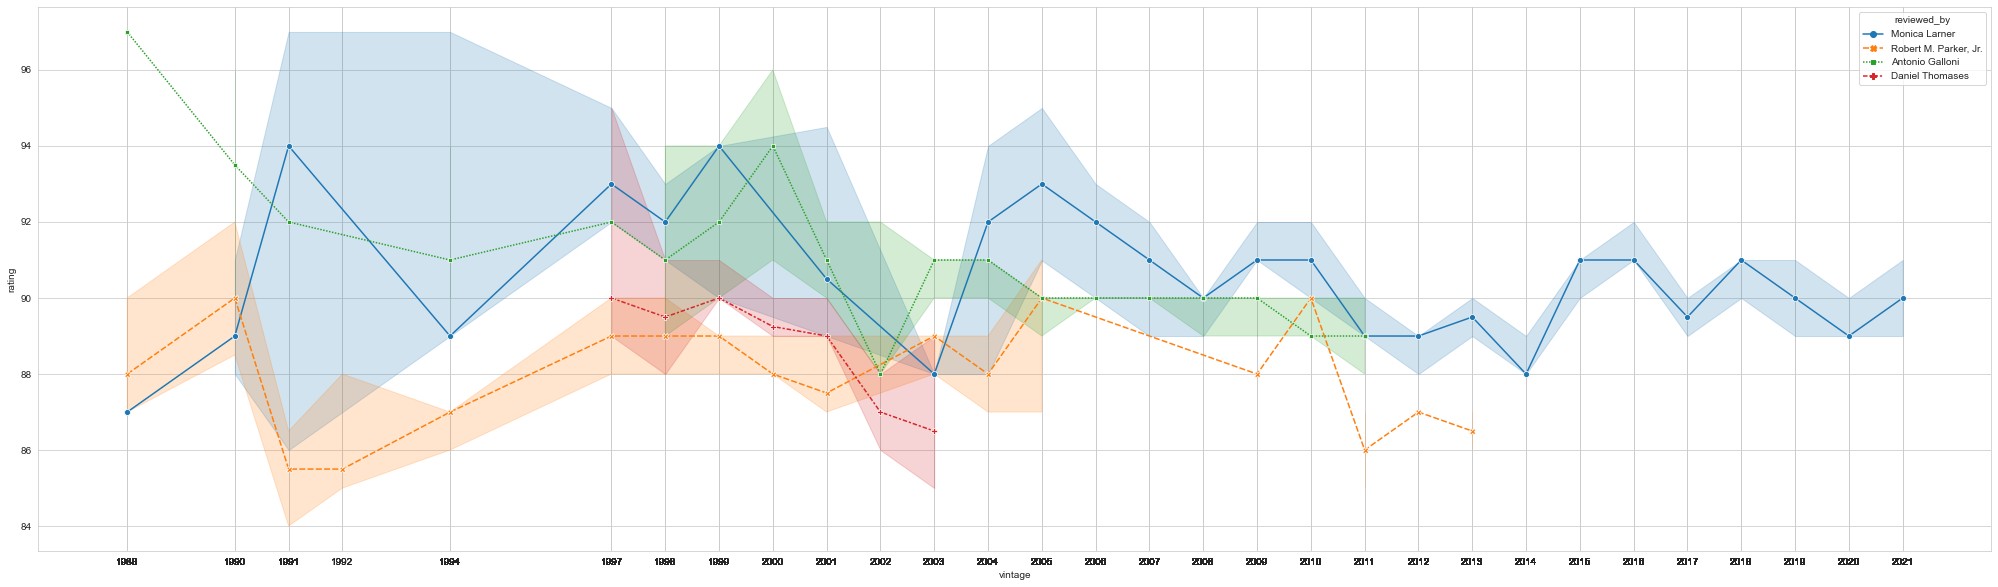

In [33]:
plt.figure(figsize=(35,10))
sns.set_style('whitegrid')
#sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'white'})
ax = sns.lineplot(data=df, x='vintage', y='rating_cleaned', hue='reviewed_by', estimator='median', style='reviewed_by', markers=True, dashes=True, err_style='band')
ax.set(xticks=df['vintage'].values)
plt.show()

# Zijn er specifieke wijnen met grote ranges van scores over de jaren heen? Of juist wijnen die het ieder jaar goed doen?

In [102]:
print(f'Number of unique values in the name column : {df.name.nunique()}')
print(f'Total number of wines: {len(df.name)}')

Number of unique values in the name column : 2821
Total number of wines: 4792


Er zijn dus ontzettend veel unieke wijnen! Kijk van iedere unieke wijn hoe vaak deze voorkomt

In [131]:
df['name_count'] = df.groupby('name')['name'].transform('count') # maak een column name_count met hoe vaak de wijn voorkomt


In [132]:
df.loc[df['name_count'] > 10] # filter op wijnen die meer dan 10x voorkomen

title  rating   drink_date  \
107                                 2021 Fattoi • Rosso    87.0   2023  2025   
108                   2021 Fattoi • Rosso di Montalcino    88.0   2023  2025   
112       2021 Fattoria dei Barbi • Rosso di Montalcino    89.0   2023  2026   
121      2021 Feudi di San Gregorio • Fiano di Avellino    91.0   2022  2025   
129                    2021 Fonzone • Fiano di Avellino    87.0   2022  2024   
...                                                 ...     ...          ...   
4889  1988 San Giusto a Rentennano • Chianti Classic...    88.0   1995  2005   
4893  1988 Sassetti Livio Pertimali • Brunello di Mo...    95.0   1996  2010   
4894  1988 Sassetti Livio Pertimali • Brunello di Mo...    94.0   1994  2014   
4895  1988 Sassetti Livio Pertimali • Rosso di Monta...    88.0   1992  1999   
4896   1988 Soldera Case Basse • Brunello di Montalcino    93.0   1994  2009   

                reviewed_by      issue_date  \
107           Monica Larner    9th Mar 2023   
108           Monica Larner    9th Mar 2023   
112           Monica Larner    9th Mar 2023   
121           Monica Larner    6th Oct 2022   
129           Monica Larner    6th Oct 2022   
...                     ...             ...   
4889  Robert M. Parker, Jr.   30th Apr 1993   
4893  Robert M. Parker, Jr.   30th Apr 1993   
4894  Robert M. Parker, Jr.   31st Oct 1994   
4895  Robert M. Parker, Jr.   28th Aug 1992   
4896  Robert M. Parker, Jr.   31st Oct 1994   

                                      source  \
107     March 2023 Week 1, The Wine Advocate   
108     March 2023 Week 1, The Wine Advocate   
112     March 2023 Week 1, The Wine Advocate   
121   October 2022 Week 1, The Wine Advocate   
129   October 2022 Week 1, The Wine Advocate   
...                                      ...   
4889                   86, The Wine Advocate   
4893                   86, The Wine Advocate   
4894                   95, The Wine Advocate   
4895                   82, The Wine Advocate   
4896                   95, The Wine Advocate   

                                                content  \
107   The entry-level Fattoi 2021 Rosso reveals a da...   
108   The 2021 Rosso di Montalcino (with 18,000 bott...   
112   This is the food-friendly, entry-level red fro...   
121   A terrific value, the Feudi di San Gregorio 20...   
129   Made in stainless steel and amphorae, the Fonz...   
...                                                 ...   
4889  This producer has released some thrilling wine...   
4893  The awesome and inspirational 1988 Brunello di...   
4894  For a number of years this microscopic estate ...   
4895  The 1988 Rossi di Montalcino offers a fragrant...   
4896  This large-scaled, intensely fragrant Brunello...   

                      producer                           from_location  color  \
107                     Fattoi                 Italy, Tuscany, Toscana    Red   
108                     Fattoi     Italy, Tuscany, Rosso di Montalcino    Red   
112         Fattoria dei Barbi     Italy, Tuscany, Rosso di Montalcino    Red   
121      Feudi di San Gregorio      Italy, Campania, Fiano di Avellino  White   
129                    Fonzone      Italy, Campania, Fiano di Avellino  White   
...                        ...                                     ...    ...   
4889   San Giusto a Rentennano        Italy, Tuscany, Chianti Classico    Red   
4893  Sassetti Livio Pertimali  Italy, Tuscany, Brunello di Montalcino    Red   
4894  Sassetti Livio Pertimali  Italy, Tuscany, Brunello di Montalcino    Red   
4895  Sassetti Livio Pertimali     Italy, Tuscany, Rosso di Montalcino    Red   
4896        Soldera Case Basse  Italy, Tuscany, Brunello di Montalcino    Red   

      ... length_content vintage length_vintage  country     region  \
107   ...          363.0    2021              4    Italy    Tuscany   
108   ...          405.0    2021              4    Italy    Tuscany   
112   ...          347.0    2021              4    I

In [156]:
df_frequent_wines = df.loc[df['name_count'] > 30]
print(df_frequent_wines.name.nunique())

9


Dus als je alleen wijnen overhoudt die meer dan 10x voorkomen in de dataset:
houd je 23 wijnen over. 23 wijnen komen meer dan 10x voor in de dataset. Die 23 wijnen kunnen we onderzoeken. 
- Hoe veranderen de scores van dezelfde wijn over tijd?
- Word eenzelfde wijn door verschillende producenten gemaakt?


<AxesSubplot: xlabel='vintage', ylabel='rating'>

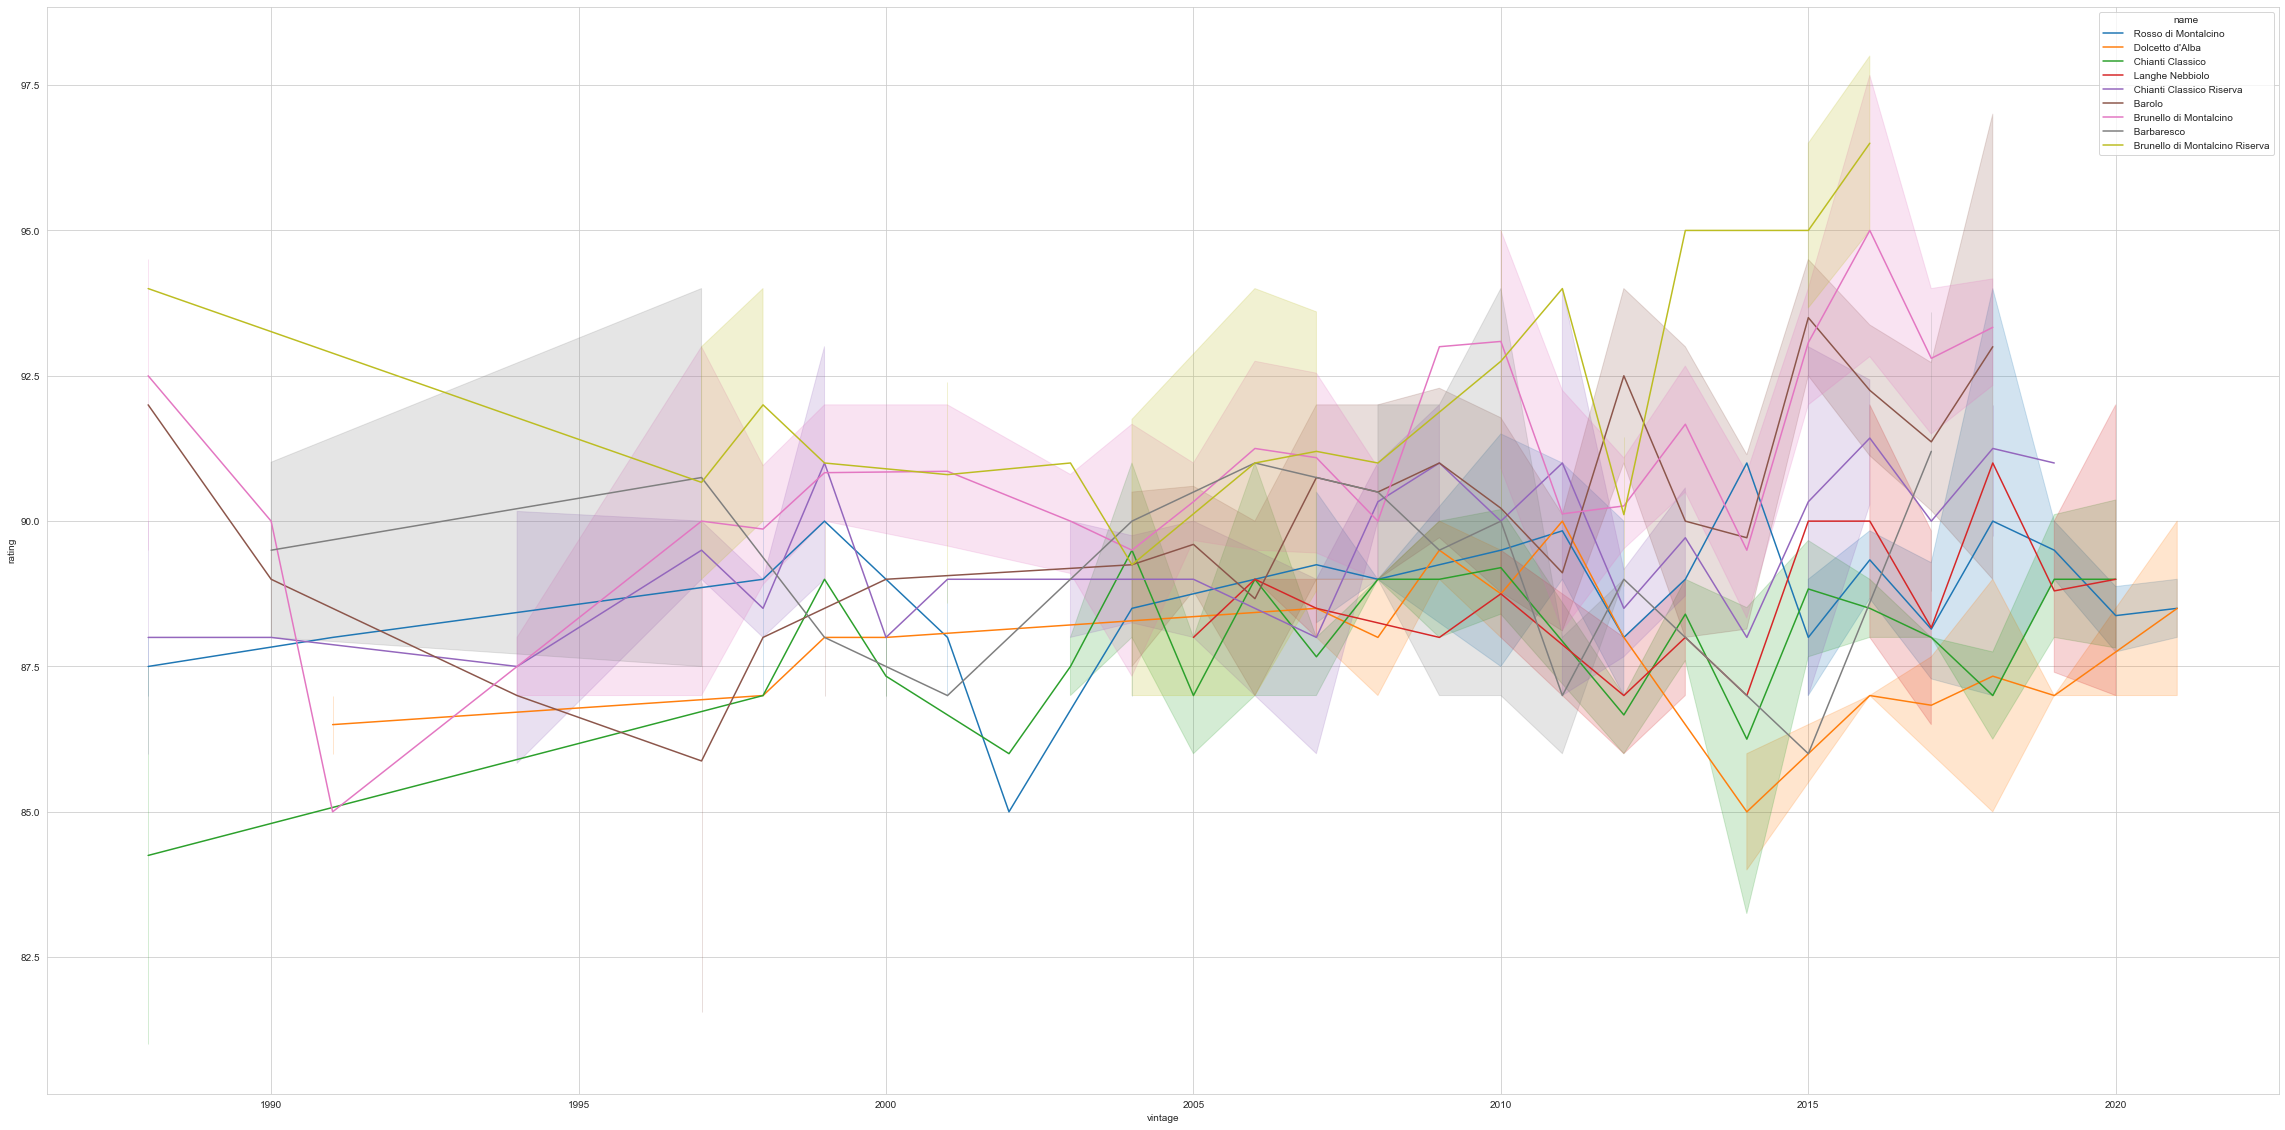

In [157]:
plt.figure(figsize=(40,20))
sns.lineplot(data=df_frequent_wines, x='vintage', y='rating_cleaned', hue='name')

Hier zie je voor iedere wijn die vaker voorkomt dan x keer, hoe die zich gedraagt door de djaren heen qua rating. Sommigen zijn strucutreel hoog, anderen hebben een uitschieter naar onder of naar boven.

<AxesSubplot: xlabel='name', ylabel='rating'>

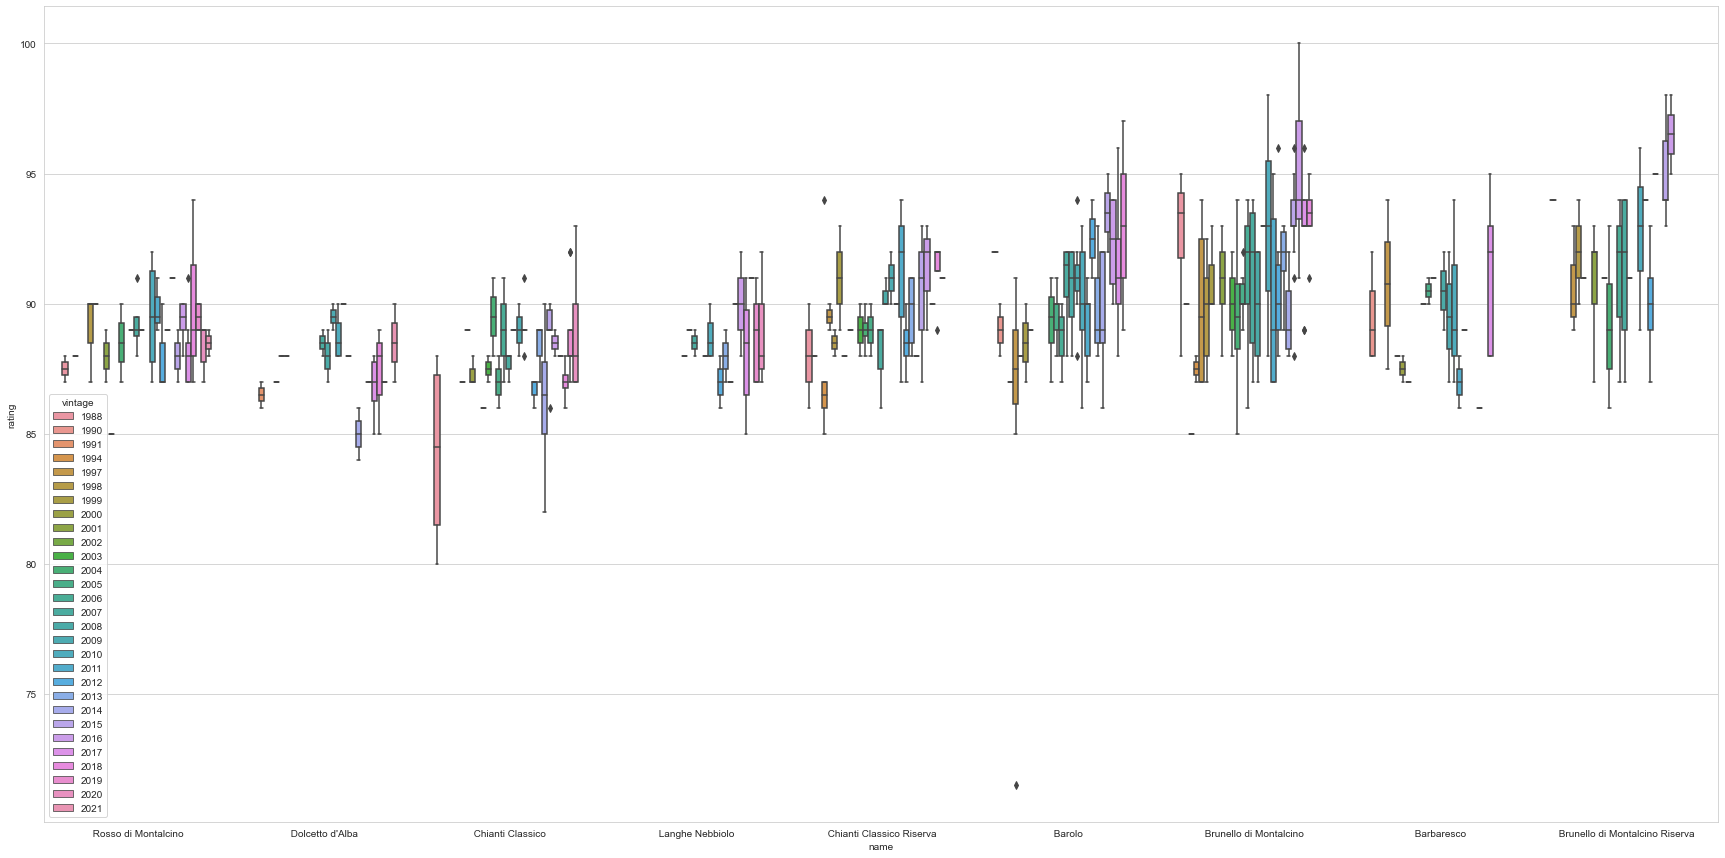

In [163]:
plt.figure(figsize=(30,15))
sns.boxplot(data=df_frequent_wines, x='name', y='rating_cleaned', hue='vintage')

# Wat is het gemiddelde en de mediaan van de scores per country (land) / region / ... (visualiseer op de kaart?)

In [165]:
df.head(2)

title  rating   drink_date  \
100  2021 Enrico Serafino • Roero Arneis Poggio di ...    88.0   2022  2024   
101  2021 Erik Banti • Maremma Toscana Vermentino S...    90.0   2022  2025   

       reviewed_by      issue_date                                 source  \
100  Monica Larner   11th Aug 2022  August 2022 Week 2, The Wine Advocate   
101  Monica Larner   25th Aug 2022  August 2022 Week 4, The Wine Advocate   

                                               content         producer  \
100  The well-priced Enrico Serafino 2021 Roero Arn...  Enrico Serafino   
101  The steel-fermented Erik Banti 2021 Maremma To...       Erik Banti   

                       from_location  color  ... length_content vintage  \
100           Italy, Piedmont, Roero  White  ...          313.0    2021   
101  Italy, Tuscany, Maremma Toscana  White  ...          334.0    2021   

    length_vintage  country     region        sub_region appellation  \
100              4    Italy   Piedmont             Roero        None   
101              4    Italy    Tuscany   Maremma Toscana        None   

    sub_appellation                                 name name_count  
100            None          Roero Arneis Poggio di Caro          1  
101            None   Maremma Toscana Vermentino Spineto          1  

[2 rows x 23 columns]

<AxesSubplot: xlabel='country', ylabel='rating'>

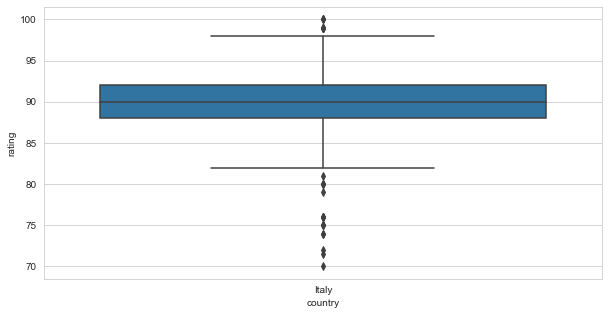

In [186]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='country', y='rating_cleaned')

<AxesSubplot: xlabel='region', ylabel='rating'>

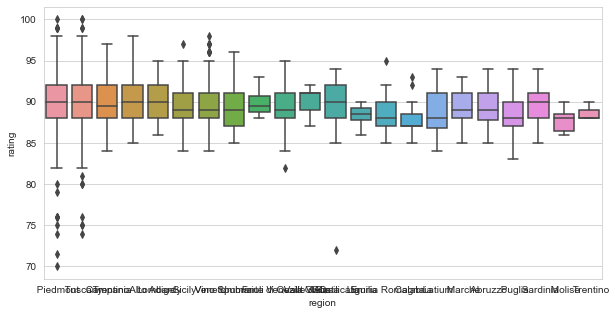

In [187]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='region', y='rating_cleaned')

<AxesSubplot: title={'center': 'Average rating over time by region'}, xlabel='vintage', ylabel='rating'>

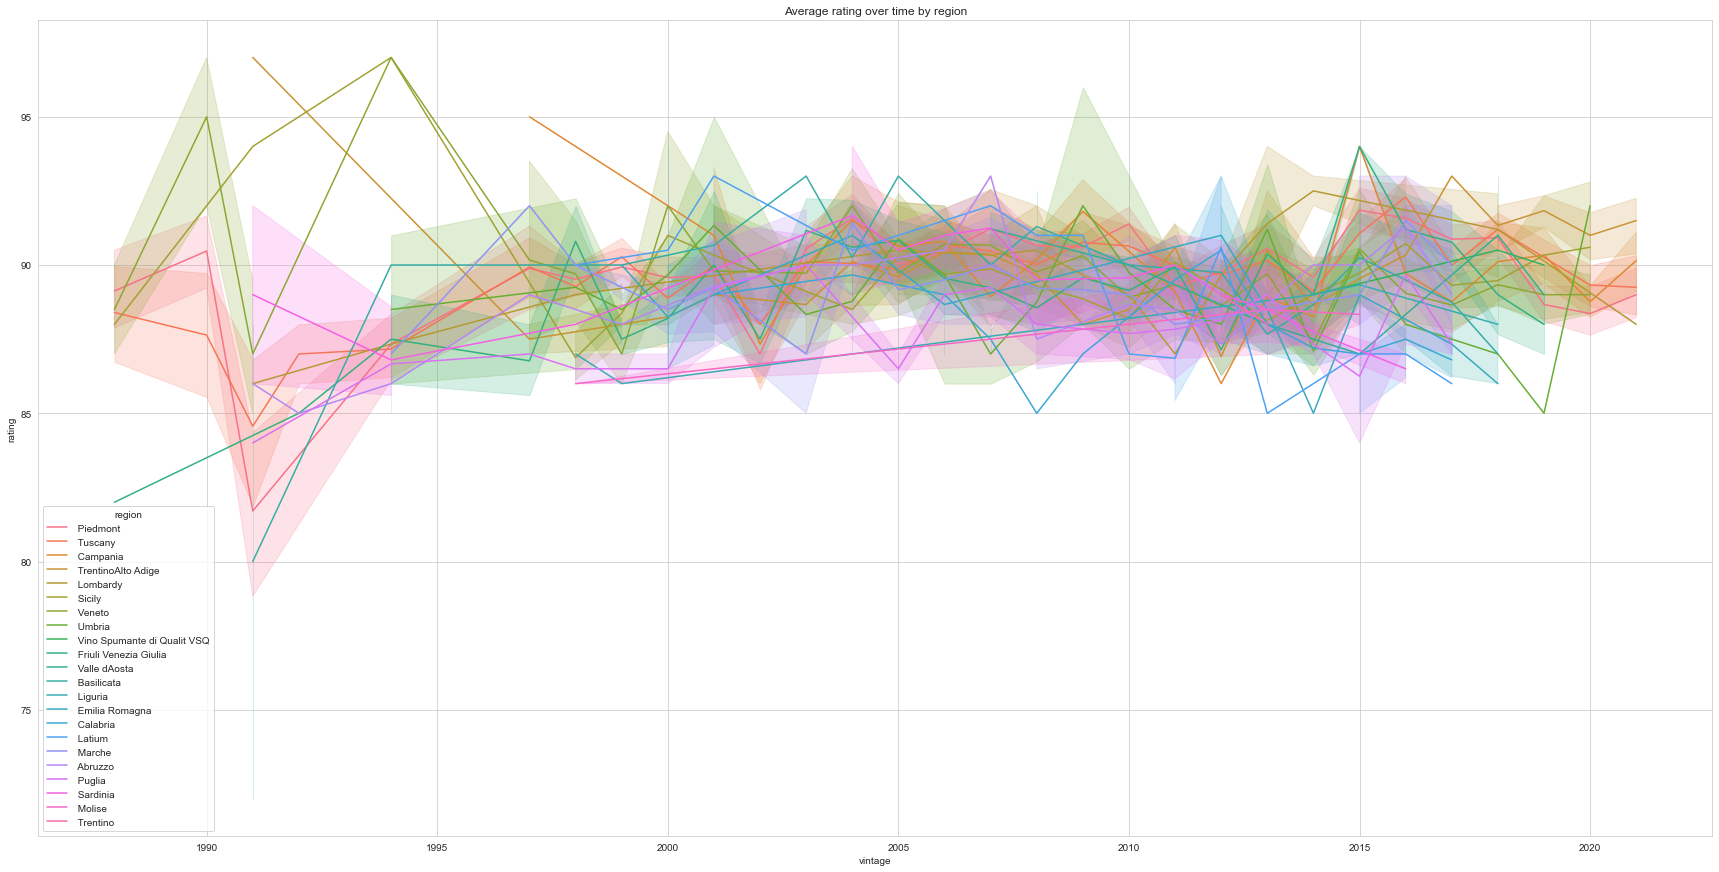

In [194]:
plt.figure(figsize=(30,15))
plt.title("Average rating over time by region")
sns.lineplot(data=df, x='vintage', y='rating_cleaned', hue='region', estimator='mean')

<AxesSubplot: title={'center': 'Median rating over time by region'}, xlabel='vintage', ylabel='rating'>

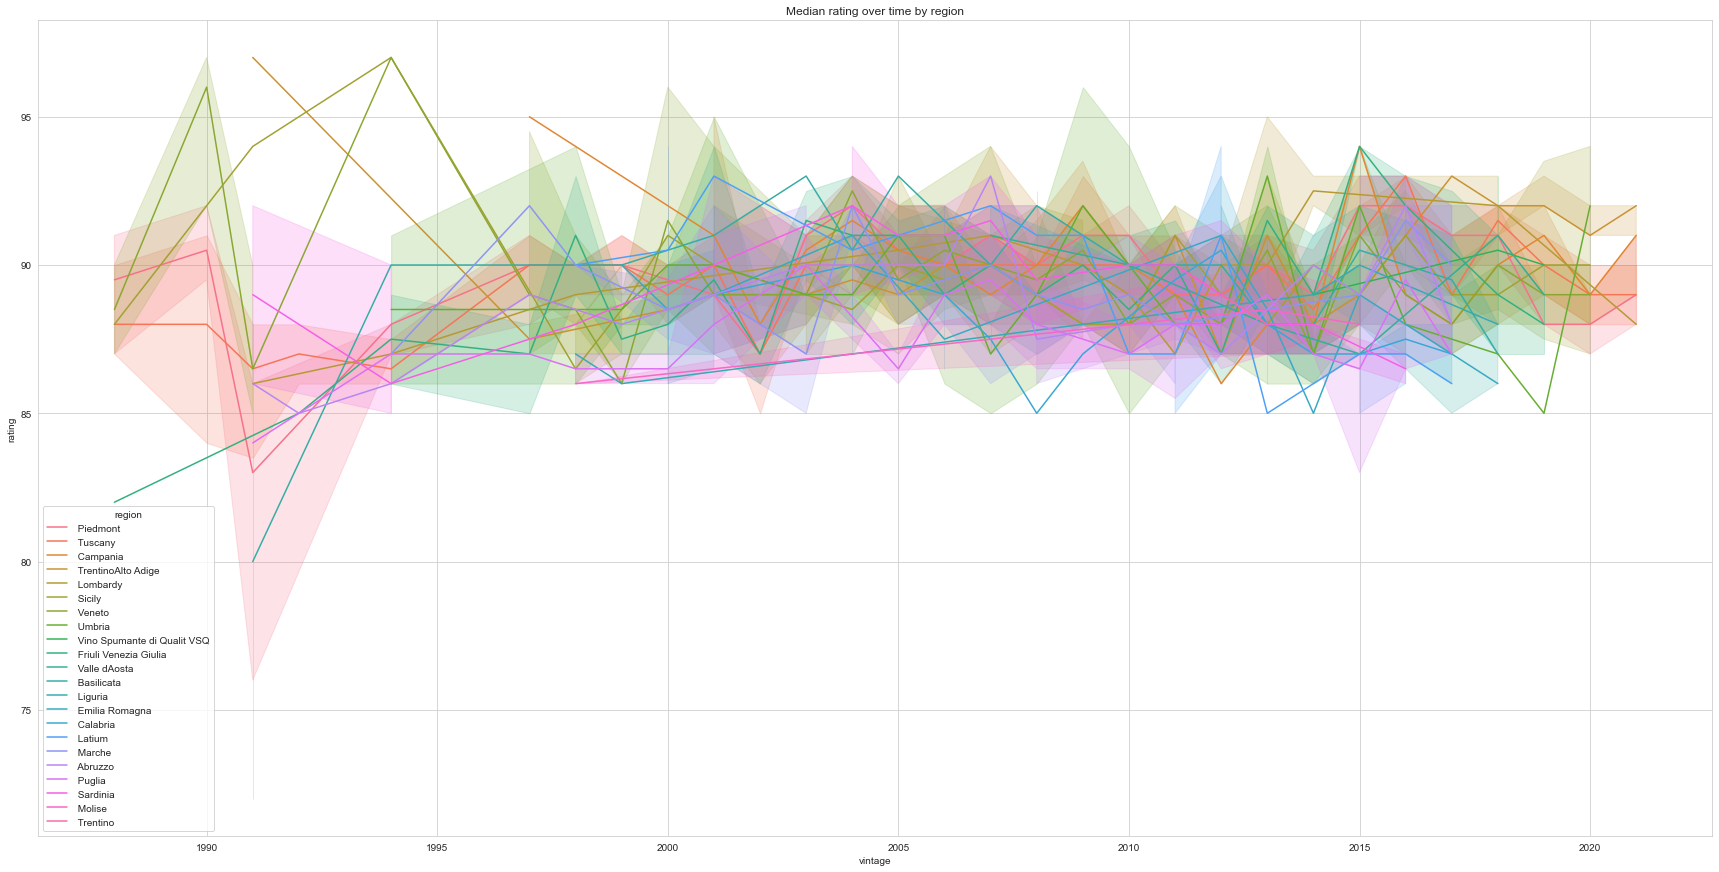

In [195]:
plt.figure(figsize=(30,15))
plt.title("Median rating over time by region")
sns.lineplot(data=df, x='vintage', y='rating_cleaned', hue='region', estimator='median')


# Zijn er producers die significant hogere ratings krijgen dan andere producers?

Dit is niet echt te doen met een lineplot, boxplot. Wellicht kijken naar de 10 producers met gemiddeld de hoogste rating en dat vergelijken met de 10 producers met gemiddelde de laagste rating. En uberhaupt vergelijken van de lijst met gemiddelde/mediaan scores per producer.

<AxesSubplot: xlabel='vintage', ylabel='rating'>

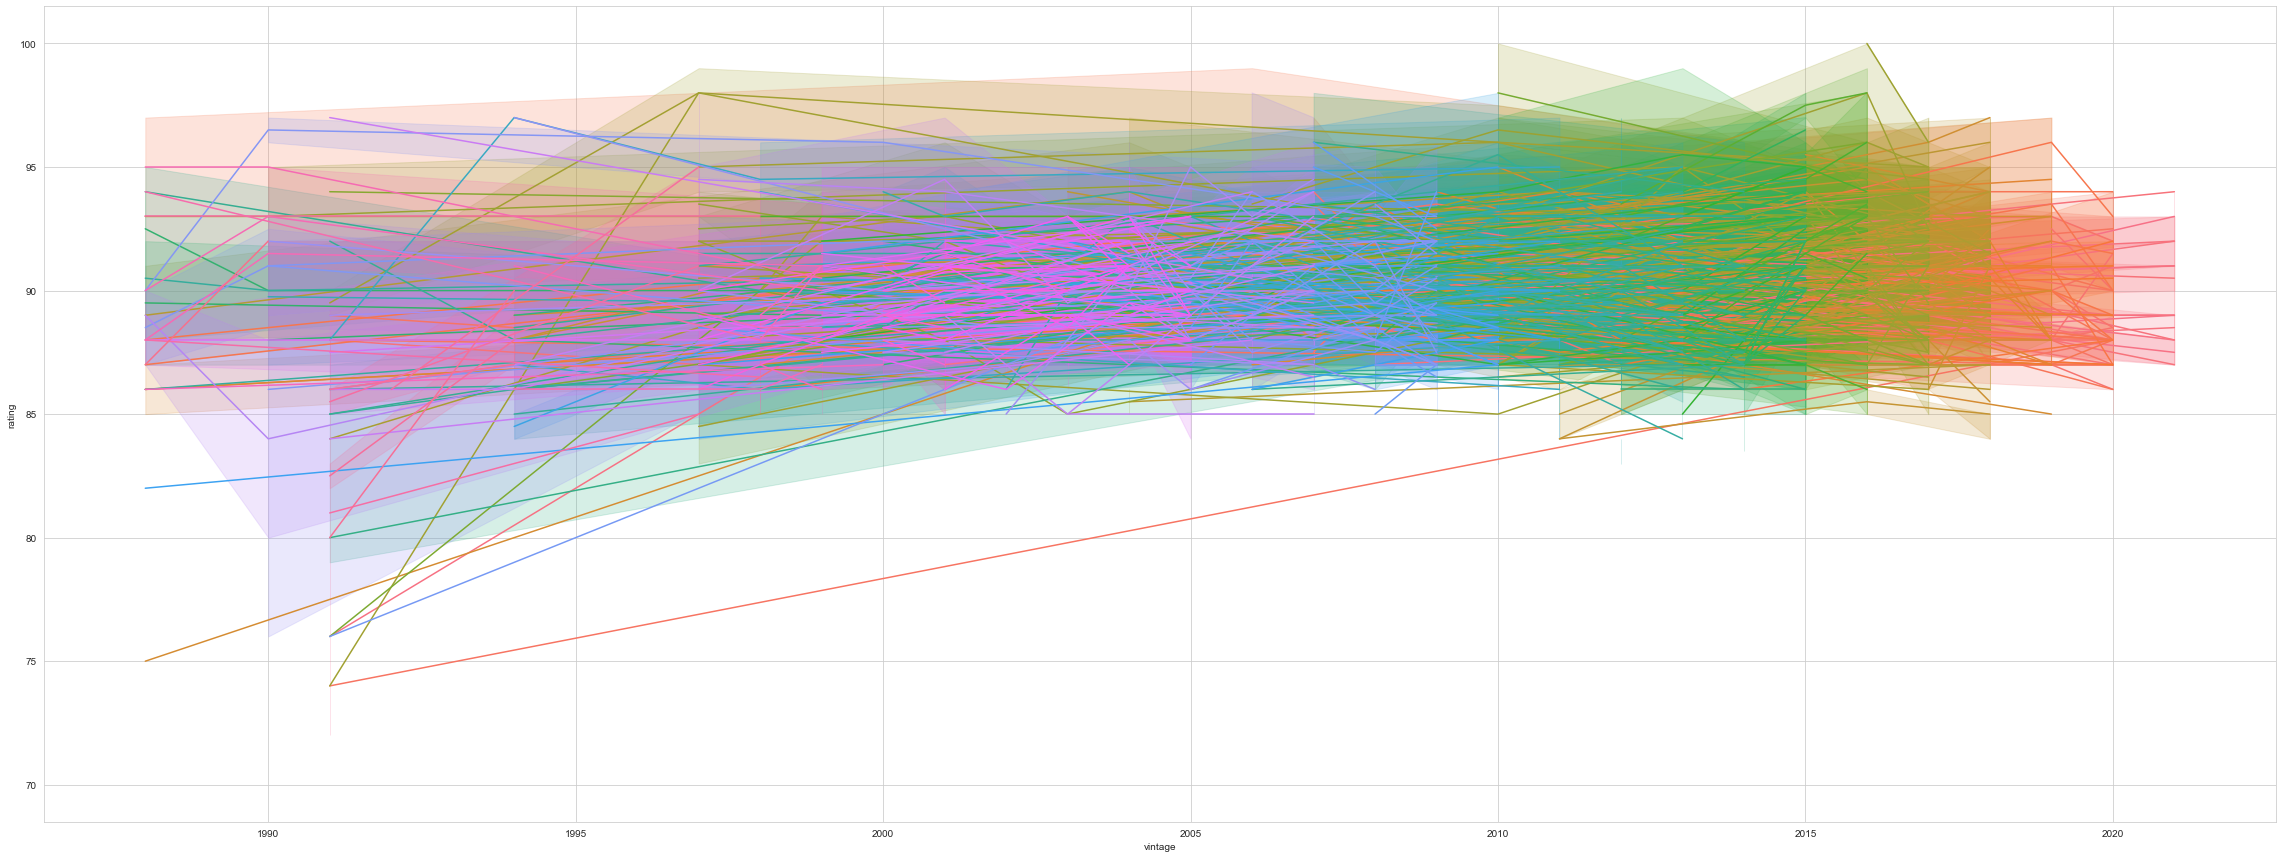

In [203]:
plt.figure(figsize=(40,15))
sns.lineplot(data=df, x='vintage', y='rating_cleaned', hue='producer', estimator='median', legend=False)

<AxesSubplot: xlabel='producer', ylabel='rating'>

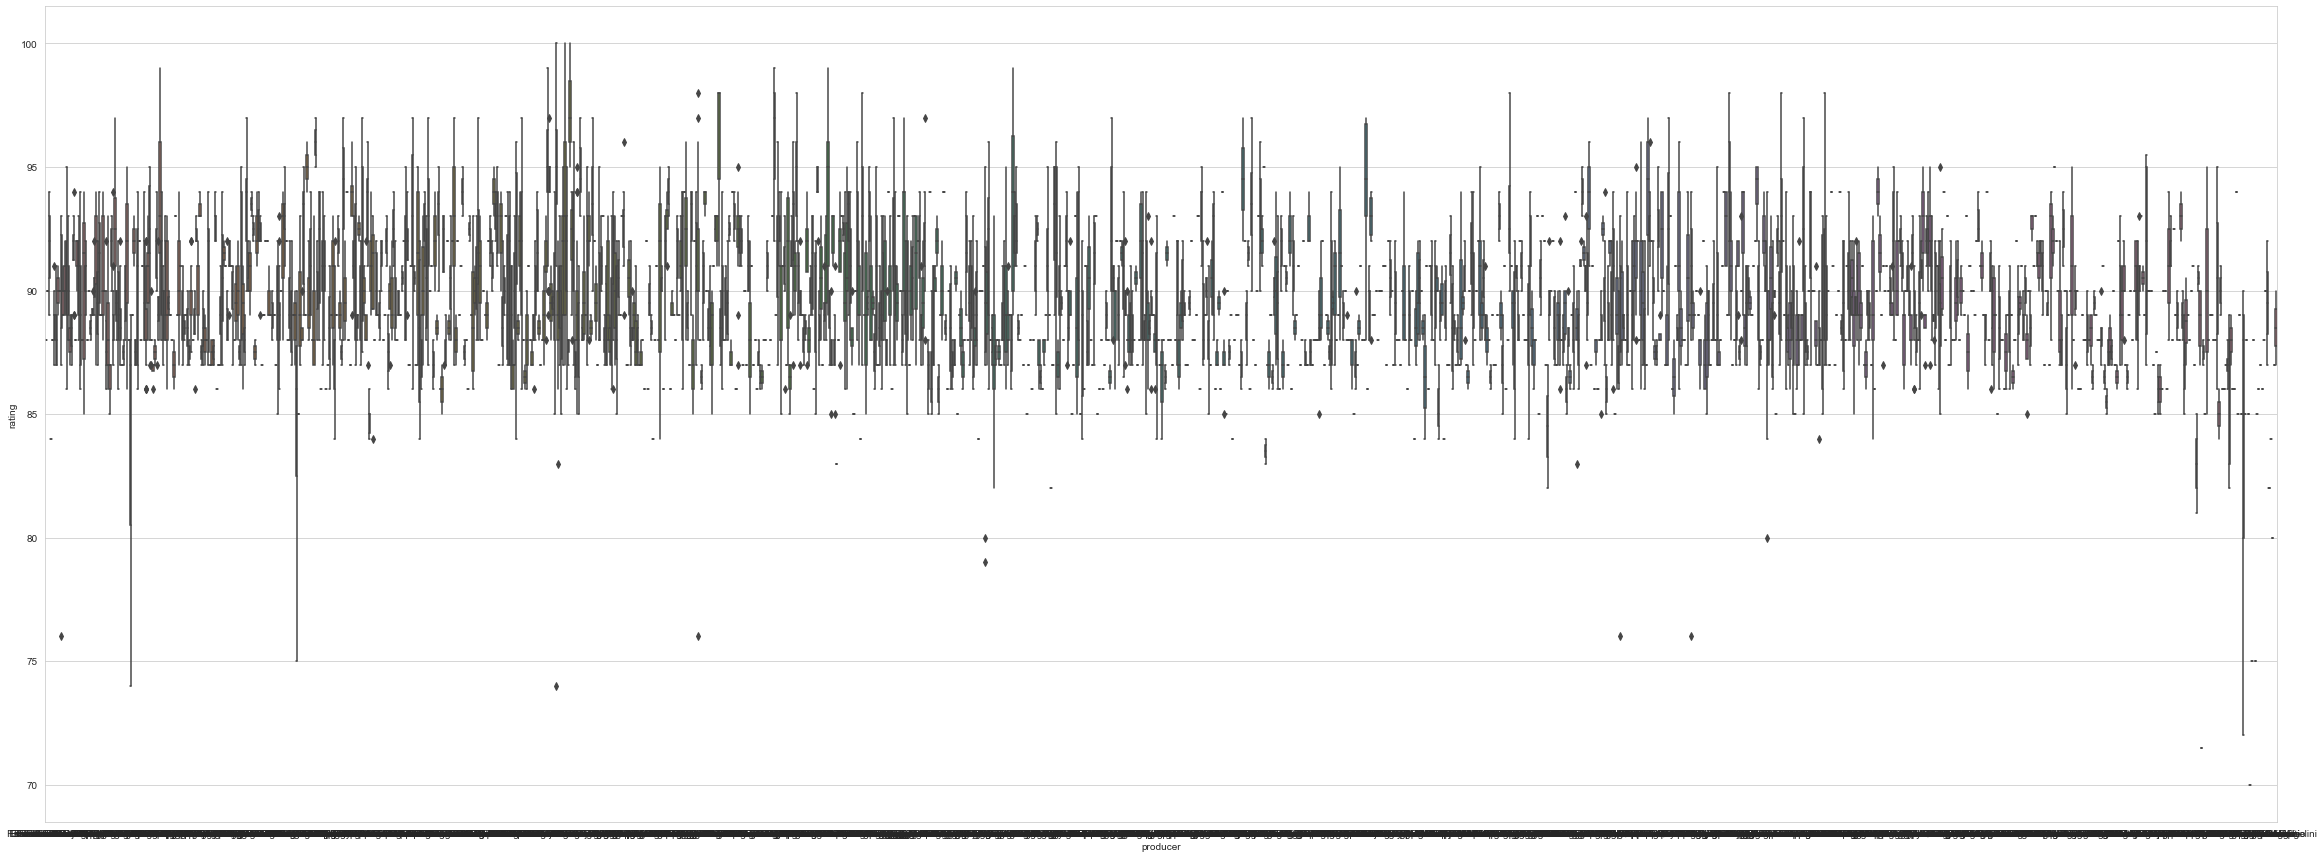

In [205]:
plt.figure(figsize=(40,15))
sns.boxplot(data=df, x='producer', y='rating_cleaned')

Een aantal duidelijke uitschieters naar onderen. Als we verder kijken naar hoevaak iedere producer voorkomt:


In [209]:
print(f'Number of unique producers: {df.producer.nunique()}')
print(f'Number of producers total: {len(df.producer)}')

Number of unique producers: 1290
Number of producers total: 4792


In [211]:
df['producer_count'] = df.groupby('producer')['producer'].transform('count') # maak een column producer_count met hoe vaak de producer voorkomt
df.head(2)

title  rating   drink_date  \
100  2021 Enrico Serafino • Roero Arneis Poggio di ...    88.0   2022  2024   
101  2021 Erik Banti • Maremma Toscana Vermentino S...    90.0   2022  2025   

       reviewed_by      issue_date                                 source  \
100  Monica Larner   11th Aug 2022  August 2022 Week 2, The Wine Advocate   
101  Monica Larner   25th Aug 2022  August 2022 Week 4, The Wine Advocate   

                                               content         producer  \
100  The well-priced Enrico Serafino 2021 Roero Arn...  Enrico Serafino   
101  The steel-fermented Erik Banti 2021 Maremma To...       Erik Banti   

                       from_location  color  ... vintage length_vintage  \
100           Italy, Piedmont, Roero  White  ...    2021              4   
101  Italy, Tuscany, Maremma Toscana  White  ...    2021              4   

    country     region        sub_region  appellation sub_appellation  \
100   Italy   Piedmont             Roero         None            None   
101   Italy    Tuscany   Maremma Toscana         None            None   

                                    name name_count producer_count  
100          Roero Arneis Poggio di Caro          1              1  
101   Maremma Toscana Vermentino Spineto          1              1  

[2 rows x 24 columns]

In [213]:
df.producer_count.describe()

count    4792.000000
mean        8.674875
std         7.770281
min         1.000000
25%         3.000000
50%         6.000000
75%        13.000000
max        44.000000
Name: producer_count, dtype: float64

Dit betekent dus dat er een producer is die 44 wijnen van de dataset heeft geproduceert. Maar er ook producenten zijn die maar één wijn van de dataset hebben geproduceert. Gemiddeld gezien heeft een producent ongeveer 9 wijnen geproduceert.

In [225]:
df_frequest_producers = df.loc[df['producer_count'] > 20] # zoek naar producers die meer dan 10 wijnen hebben geproduceert.
df_frequest_producers.producer.nunique()

13

Nu gezocht naar minimaal 20 wijnen per producer : 

In [227]:
df_frequest_producers.head(2)

title  rating   drink_date  \
119  2021 Feudi di San Gregorio • Falanghina del Sa...    89.0   2022  2024   
120  2021 Feudi di San Gregorio • Falanghina del Sa...    91.0   2022  2025   

       reviewed_by     issue_date                                  source  \
119  Monica Larner   6th Oct 2022  October 2022 Week 1, The Wine Advocate   
120  Monica Larner   6th Oct 2022  October 2022 Week 1, The Wine Advocate   

                                               content               producer  \
119  Offering white flower, nectarine, quince and p...  Feudi di San Gregorio   
120  Packaged in its pretty ribbed bottle, the 2021...  Feudi di San Gregorio   

                              from_location  color  ... vintage  \
119  Italy, Campania, Falanghina del Sannio  White  ...    2021   
120  Italy, Campania, Falanghina del Sannio  White  ...    2021   

    length_vintage country     region              sub_region  appellation  \
119              4   Italy   Campania   Falanghina del Sannio         None   
120              4   Italy   Campania   Falanghina del Sannio         None   

    sub_appellation                               name name_count  \
119            None              Falanghina del Sannio          4   
120            None   Falanghina del Sannio Serrocielo          1   

    producer_count  
119             44  
120             44  

[2 rows x 24 columns]

Nu kunnen we kijken of er verschillen tussen deze zitten:

<AxesSubplot: xlabel='vintage', ylabel='rating'>

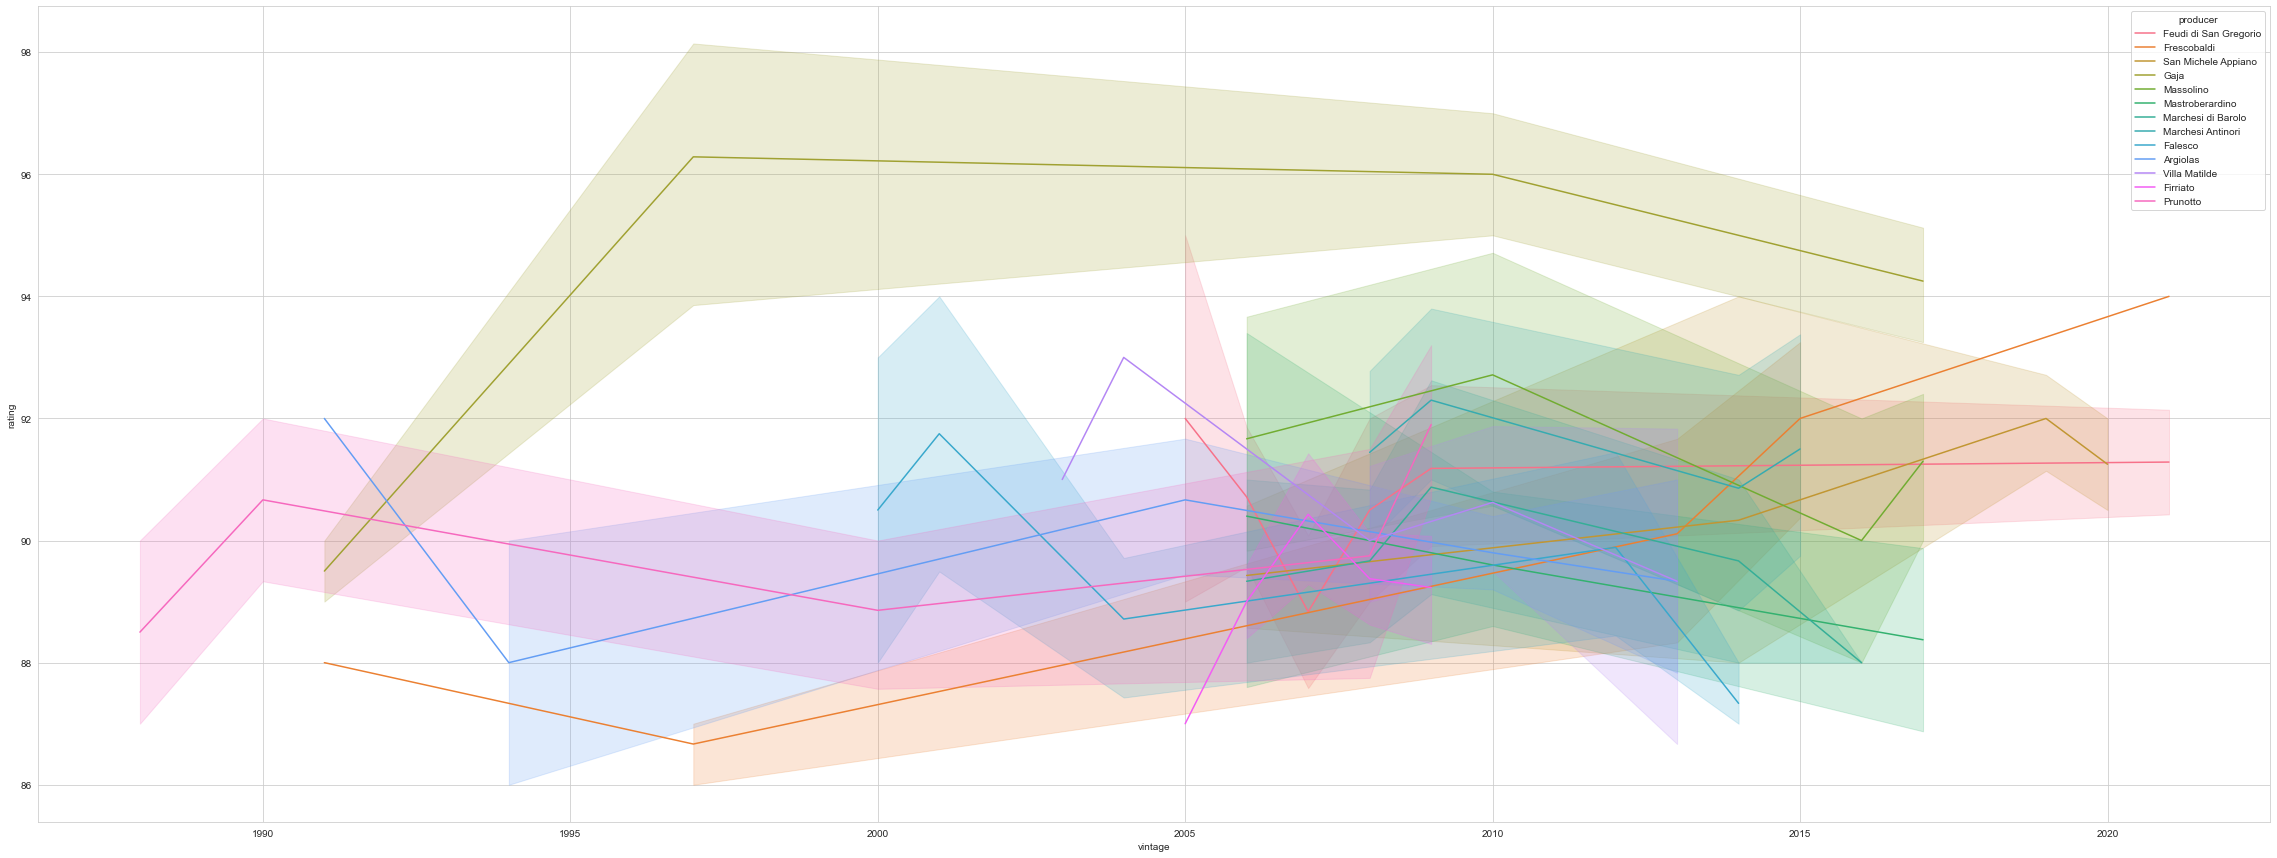

In [232]:
plt.figure(figsize=(40,15))
sns.lineplot(data=df_frequest_producers, x='vintage', y='rating_cleaned', hue='producer', estimator='mean')

<AxesSubplot: xlabel='producer', ylabel='rating'>

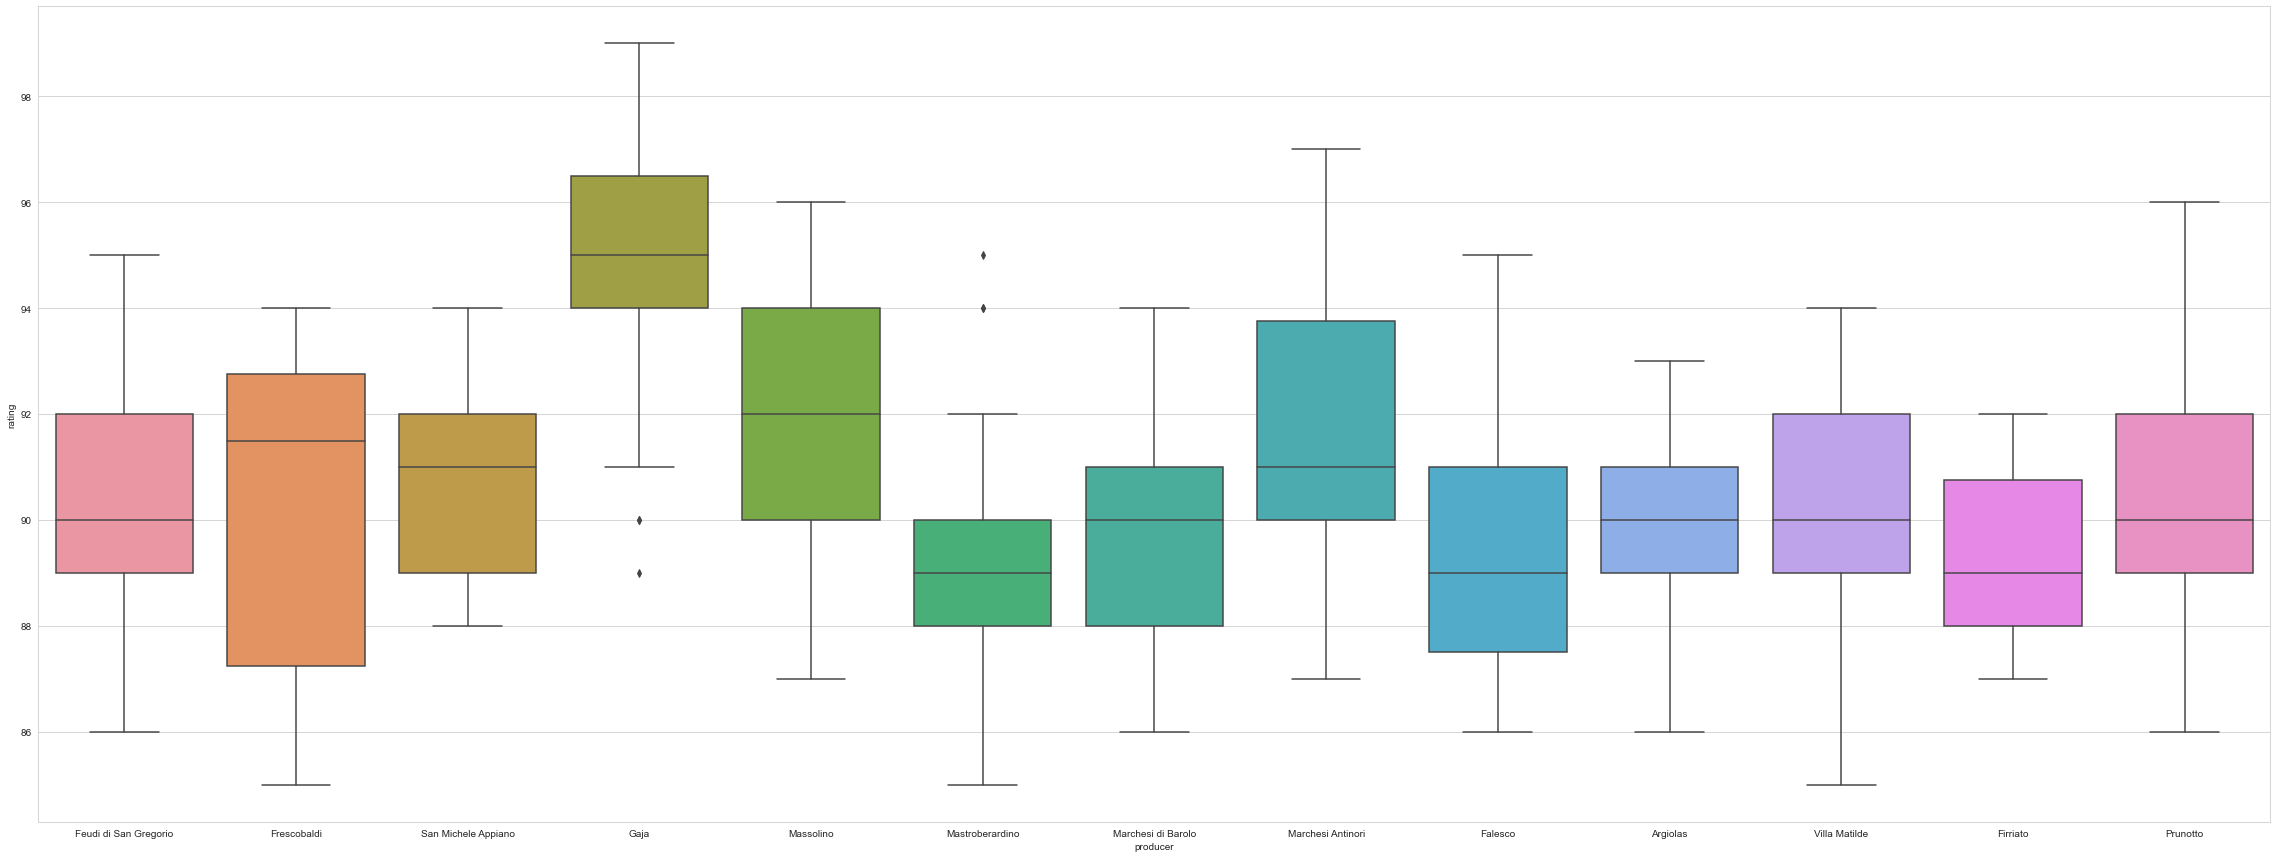

In [228]:
plt.figure(figsize=(40,15))
sns.boxplot(data=df_frequest_producers, x='producer', y='rating_cleaned')

In [149]:
# Per producer het gemiddelde berekenen en toevoegen als kolom?

In [152]:
len(df.index)

87630

In [260]:
df['producer_average']=  df.groupby('producer')['rating_cleaned'].transform('mean')
df.head(10)

title  rating   drink_date  \
100  2021 Enrico Serafino • Roero Arneis Poggio di ...    88.0   2022  2024   
101  2021 Erik Banti • Maremma Toscana Vermentino S...    90.0   2022  2025   
102  2021 Ettore Sammarco • Costa d'Amalfi Ravello ...    92.0   2022  2025   
103  2021 Ettore Sammarco • Costa d'Amalfi Ravello ...    94.0   2022  2028   
104  2021 Fabio de Beaumont • La Baronessa Bianco F...    84.0   2022  2023   
105   2021 Fabrizio Dionisio • Syrah Rosa del Castagno    88.0   2022  2024   
106                          2021 Fanti • Poggio Torto    89.0   2023  2025   
107                                2021 Fattoi • Rosso    87.0   2023  2025   
108                  2021 Fattoi • Rosso di Montalcino    88.0   2023  2025   
109  2021 Fattoria Mantellassi • Maremma Toscana Ci...    89.0   2022  2025   

       reviewed_by      issue_date  \
100  Monica Larner   11th Aug 2022   
101  Monica Larner   25th Aug 2022   
102  Monica Larner    6th Oct 2022   
103  Monica Larner    6th Oct 2022   
104  Monica Larner    6th Oct 2022   
105  Monica Larner   30th Dec 2022   
106  Monica Larner    9th Mar 2023   
107  Monica Larner    9th Mar 2023   
108  Monica Larner    9th Mar 2023   
109  Monica Larner   25th Aug 2022   

                                                source  \
100              August 2022 Week 2, The Wine Advocate   
101              August 2022 Week 4, The Wine Advocate   
102             October 2022 Week 1, The Wine Advocate   
103             October 2022 Week 1, The Wine Advocate   
104             October 2022 Week 1, The Wine Advocate   
105  Issue 264 End of December 2022, The Wine Advocate   
106               March 2023 Week 1, The Wine Advocate   
107               March 2023 Week 1, The Wine Advocate   
108               March 2023 Week 1, The Wine Advocate   
109              August 2022 Week 4, The Wine Advocate   

                                               content              producer  \
100  The well-priced Enrico Serafino 2021 Roero Arn...       Enrico Serafino   
101  The steel-fermented Erik Banti 2021 Maremma To...            Erik Banti   
102  This is a terrific value, and I am an unabashe...       Ettore Sammarco   
103  This is a beautiful but feisty wine that is te...       Ettore Sammarco   
104  Executed in a quasi pét-nat style, the Fabio d...     Fabio de Beaumont   
105  The organic Fabrizio Dionisio 2021 Syrah Rosa ...     Fabrizio Dionisio   
106  Here's a new wine from Fanti. Young, crisp and...                 Fanti   
107  The entry-level Fattoi 2021 Rosso reveals a da...                Fattoi   
108  The 2021 Rosso di Montalcino (with 18,000 bott...                Fattoi   
109  The Fattoria Mantellassi 2021 Maremma Toscana ...  Fattoria Mantellassi   

                           from_location  color  ... length_vintage country  \
100               Italy, Piedmont, Roero  White  ...              4   Italy   
101      Italy, Tuscany, Maremma Toscana  White  ...              4   Italy   
102       Italy, Campania, Costa dAmalfi  White  ...              4   Italy   
103       Italy, Campania, Costa dAmalfi  White  ...              4   Italy   
104                      Italy, Campania  White  ...              4   Italy   
105              Italy, Tuscany, Toscana    Ros  ...              4   Italy   
106              Italy, Tuscany, Toscana    Red  ...              4   Italy   
107              Italy, Tuscany, Toscana    Red  ...              4   Italy   
108  Italy, Tuscany, Rosso di Montalcino    Red  ...              4   Italy   
109      Italy, Tuscany, Maremma Toscana    Red  ...              4   Italy   

        region            sub_region  appellation  sub_appellation  \
100   Piedmont                 Roero         None             None   
101    Tuscany       Maremma Toscana         None             None   
102   Campania         Costa dAmalfi         None             None   
103   Campania         Costa dAmalfi         None             None   
104   Campania      

In [262]:
df.describe()

rating  length_content      vintage  length_vintage   name_count  \
count  4792.000000     4792.000000  4792.000000          4792.0  4792.000000   
mean     89.940839      552.784224  2009.415067             4.0    15.977880   
std       2.819835      302.492201     7.174880             0.0    38.635281   
min      70.000000       22.000000  1988.000000             4.0     1.000000   
25%      88.000000      381.000000  2005.000000             4.0     1.000000   
50%      90.000000      478.000000  2010.000000             4.0     2.000000   
75%      92.000000      625.000000  2015.000000             4.0     5.000000   
max     100.000000     3453.000000  2021.000000             4.0   181.000000   

       producer_count  producer_average  
count     4792.000000       4792.000000  
mean         8.674875         89.940839  
std          7.770281          2.018927  
min          1.000000         70.000000  
25%          3.000000         88.666667  
50%          6.000000         89.909091  
75%         13.000000         91.250000  
max         44.000000         97.333333

Big differences between the min and max from producer_average. Note: this is  already the average per producer. Which is the lowest average scoring producer? And who the max average scoring producer? :

In [291]:
df.loc[df['producer_average'].idxmax()]

title                                          2017 Masseto • Masseto
rating                                                           97.0
drink_date                                                 2024  2050
reviewed_by                                             Monica Larner
issue_date                                              21st May 2020
source                             May 2020 Week 3, The Wine Advocate
content             The Masseto 2017 Masseto puts on another exhil...
producer                                                      Masseto
from_location                                 Italy, Tuscany, Toscana
color                                                             Red
type                                                            Table
sweetness                                                         Dry
variety                                                        Merlot
length_content                                                 2333.0
vintage             

In [292]:
df.producer[df['producer_average'].idxmax()]

'Masseto'

In [293]:
df.producer_average.min()

70.0

In [294]:
df.loc[df['producer_average'].idxmin()]

title                 1991 Cassinis • Barbera del Monfarato
rating                                                 70.0
drink_date                                               NA
reviewed_by                           Robert M. Parker, Jr.
issue_date                                    31st Oct 1994
source                                95, The Wine Advocate
content                         Tasted but not recommended.
producer                                           Cassinis
from_location       Italy, Piedmont, Barbera del Monferrato
color                                                   Red
type                                                  Table
sweetness                                               Dry
variety                                             Barbera
length_content                                         27.0
vintage                                                1991
length_vintage                                            4
country                                 

In [295]:
df.producer[df['producer_average'].idxmin()]

'Cassinis'

Zijn de scores van pure wijnen significant hoger dan blends (variety)?

<AxesSubplot: xlabel='variety', ylabel='rating'>

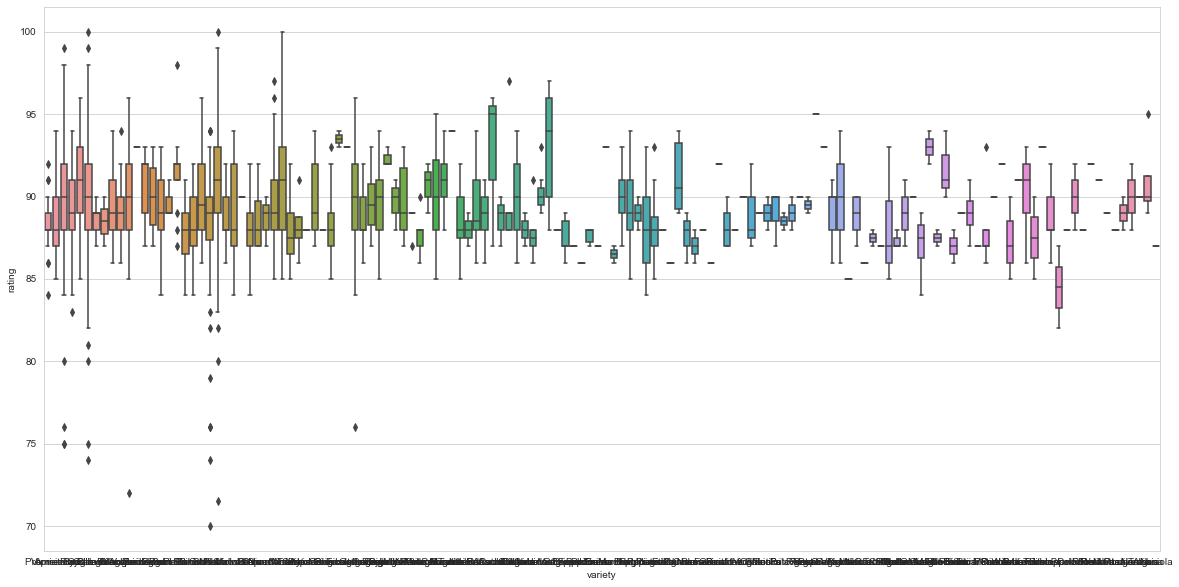

In [297]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df, x='variety', y='rating_cleaned')